# X-ray detected Be star catalog

**Caden Gobat**<sup>1</sup> & **Hui Yang**<sup>1</sup>

<sup>1</sup>The George Washington University

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, sympy, matplotlib as mpl
from astropy.io import fits, ascii as ascii_io, votable
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.table import Table
from gdpyc import GasMap, DustMap

from scipy import stats, optimize
import math
from collections import Counter
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from asymmetric_uncertainty import AsymmetricUncertainty

In [3]:
BeSS = ascii_io.read("./catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'hourangle').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
BeSS.pprint()

 #    Be star    Category ...       _RAJ2000            _DEJ2000     
                          ...         deg                 deg        
---- ---------- --------- ... ------------------- -------------------
   1 BD+62 2346 Classical ... 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical ... 0.41095833333333326   60.44992222222222
   3  HD 225095 Classical ...  0.8631249999999999   55.55089722222222
   4      2 Cet Classical ...  0.9349583333333332 -17.335991666666665
   5     10 Cas Classical ...  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical ...  1.7012499999999997  60.600230555555555
 ...        ...       ... ...                 ...                 ...
2258   V818 Cas Classical ...   357.4713333333333   62.21409166666667
2259 EM* AS 518 Classical ...  359.38362499999994   72.88435833333334
2260 BD+65 1970 Classical ...   359.3920833333333   66.43162222222223
2261     LQ And Classical ...   359.6934999999999  46.413177777777776
2262  HD 224544 Clas

## After manual investigation, the coordinates of the following Be stars from the BeSS catalog have relatively large positional uncertainties (1"-5") which are updated here

In [4]:

indexs =    [68,        42,         47,         49,         230,       237,        253,      272,       274,        260,      296,     1630]

gaia_ras =  [13.02345,   12.142170,  12.306773,  12.374212,  14.400078,14.552446,  15.262034,16.290251, 16.480222,  15.467899,19.633210,215.300650]
gaia_decs = [-72.434514, -73.042030, -73.193853, -73.182921, -72.326132,-72.513544,-72.116379,-72.196375,-72.064044,-72.392790,63.742520,-62.698914]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    #print(BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'])
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'] = ra, dec 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])
    
BeSS['conf_flag'] = 0

indexs =    [760,      767,      150,       215,            516,      857,       1410,           1478,      1604,          2074,      189,          1715,      1930,      139,      1375,            857,            1475,             79,          120,         226,              265,                   1243,           1331,        1574,     1926]

gaia_ras =  [80.124405,80.691452,13.957651, 14.16150651198, 34.809579,83.920304, 165.62489467958,174.7414595,207.402686,   303.73052859,14.08276055767,241.011158,274.692197,13.896433, 161.47374583153,83.92084433997, 174.58301532056,13.34460251277,13.72732352852,14.29036126271,15.9064071959,       133.34164824874,156.50072742424,198.54794100157,274.63838149679]
gaia_decs = [-69.532146,33.416338,-72.452880,-72.30366663757,57.184698,-66.864928,-60.81551722574,-63.4774941368,-42.473011,36.8535390968,-72.46714301601,-47.477649,-13.910324,-72.485176, -59.95105371342,-66.86487936541,-63.34347837499,-72.19883641895,-72.45661959811,-72.44935286279,-72.02589539658,-46.03576523452,-57.82691748014,-63.37375307540,-13.75223648534]

for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])


       Be star         _RAJ2000  _DEJ2000 
                         deg       deg    
--------------------- --------- ----------
            X SMC X-3  13.02345 -72.434514
      RX J0048.5-7302  12.14217  -73.04203
      RX J0049.2-7311 12.306773 -73.193853
      RX J0049.5-7310 12.374212 -73.182921
CXOU J005736.2-721934 14.400078 -72.326132
      RX J0058.2-7231 14.552446 -72.513544
      RX J0101.0-7206 15.262034 -72.116379
      RX J0105.3-7210 16.290251 -72.196375
      RX J0105.9-7203 16.480222 -72.064044
      RX J0101.8-7223 15.467899  -72.39279
            CAS GAM-1  19.63321   63.74252
           4U 1416-62 215.30065 -62.698914
       Be star             _RAJ2000        _DEJ2000   
                             deg             deg      
---------------------- --------------- ---------------
            [HP99] 946       80.124405      -69.532146
 Cl* NGC 1893 CUF 3104       80.691452       33.416338
      Cl* NGC 330 G 68       13.957651       -72.45288
Cl* NGC 330 ELS 004509  1

In [5]:
print(BeSS[1375][['Be star','_RAJ2000','_DEJ2000']])

       Be star             _RAJ2000        _DEJ2000   
                             deg             deg      
---------------------- --------------- ---------------
Cl* Trumpler 16 MJ 632 161.47374583153 -59.95105371342


In [6]:
def find_nearest(df, ind_col='_q', sep_col='_r', check=False, drop=False):
    
    '''
    drop multiple matches for the source with the same ind_col column by keeping the nearest match of sep_col column
    '''
    
    print('Before cleaning multiple matches:', len(df), 'rows.')
    df_nearest = pd.DataFrame(columns=[ind_col])
    for i in df[ind_col].unique():
        df_sub = df.loc[df[ind_col]==i]
        instances = len(df_sub)
        if instances == 0:
            pass
        elif drop and i in drop:
            pass
        else:
            if check and instances>1:
                print(df_sub)
                
            df_src = df_sub.loc[df_sub[sep_col] ==min(df_sub[sep_col])]
            if len(df_src)>1:
                df_nearest = pd.concat([df_nearest, df_src.head(1)])
            else:
                df_nearest = pd.concat([df_nearest, df_src])
    print('After cleaning multiple matches:', len(df_nearest), 'rows.')
    return df_nearest


In [7]:
# matching to gaiaedr3

v = Vizier(columns=['all', 'DR3Name','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

# match BeSS to gaiaedr3 using 2"
Gaia_BeSS_2as = v.query_region(BeSS, catalog="I/355/gaiadr3", radius="2s")
Gaia_matched = Gaia_BeSS_2as[0]["_q","_r","Source","RA_ICRS","DE_ICRS","DR3Name","Plx","RPlx","pmRA","pmDE","epsi","sepsi","RUWE","Gmag","BPmag","RPmag","Teff"]
Gaia_matched['Source'] = Gaia_matched['Source'].astype(str)
gaia_df = Gaia_matched.to_pandas()
gaia_df = gaia_df.dropna(subset=['_r'])
#gaia_df = gaia_df.rename(columns={'Source':'Source2'})
#gaia_df['Source'] = gaia_df.apply(lambda row: row.EDR3Name[10:], axis=1)

# Removing Be stars that are matched to the same Gaia eDR3 sources, 
# those are mostly duplicated Be stars that have slightly different coordinates 
df_gaiaedr3 = find_nearest(gaia_df, ind_col='Source', sep_col='_r', check=False, drop=False)


Before cleaning multiple matches: 2486 rows.
After cleaning multiple matches: 2464 rows.


In [8]:
# matching to gaiaedr3dist to get the distance info.

v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

# match BeSS to gaiaedr3dist using 2"
Gaiadist_BeSS_2as = v.query_region(BeSS, catalog="I/352/gedr3dis", radius="2s")
Gaiadist_matched = Gaiadist_BeSS_2as[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]
Gaiadist_matched['Source'] = Gaiadist_matched['Source'].astype(str)

gaiadist_df = Gaiadist_matched.to_pandas()
df_gaiadist = find_nearest(gaiadist_df, ind_col='Source', sep_col='_r', check=False, drop=False)



Before cleaning multiple matches: 2327 rows.
After cleaning multiple matches: 2312 rows.


In [9]:
# matching to gaia dr3 physical parameter catalog

v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

# match BeSS to gaiaedr3dist using 2"
Gaiaparamp_BeSS_2as = v.query_region(BeSS, catalog="I/355/paramp", radius="2s")
#'''
Gaiaparamp_matched = Gaiaparamp_BeSS_2as[0]["_q","_r","Source","Pstar","SpType-ELS"]
#Gaiaparamp_matched['Source'].mask = [True]*len(Gaiaparamp_matched)
Gaiaparamp_matched['Source'] = Gaiaparamp_matched['Source'].astype(str)
gaiaparamp_df = Gaiaparamp_matched.to_pandas()
#gaiaparamp_df = gaiaparamp_df.rename(columns={'Source':'Source2'})
df_gaiaparamp = find_nearest(gaiaparamp_df, ind_col='Source', sep_col='_r', check=False, drop=False)

#'''

Before cleaning multiple matches: 2219 rows.
After cleaning multiple matches: 2210 rows.


In [10]:
df_gaia_comb = pd.merge(df_gaiaedr3, df_gaiadist, on='Source', how="outer")
print(len(df_gaia_comb))
print(len(gaiaparamp_df))
df_gaia_comb = pd.merge(df_gaia_comb, df_gaiaparamp, on='Source', how="outer")
print(len(df_gaia_comb))
df_gaia_comb = df_gaia_comb.rename(columns={'_q':'_q_dr3'})
df_gaia_comb = df_gaia_comb.rename(columns={'_q_x':'_q'})
df_gaia_comb = df_gaia_comb.rename(columns={'_r':'_r_dr3'})
df_gaia_comb = df_gaia_comb.rename(columns={'_r_x':'_r'})

2464
2219
2464


In [11]:
# combing gaiaedr3 and gaiaedr3dist matching results and calculating color BP-RP and absolute magnitude of BPmag

df_gaia_comb['BP-RP'] = df_gaia_comb['BPmag']-df_gaia_comb['RPmag']

df_gaia_comb['abs_BPmag'] = df_gaia_comb['BPmag']-5*(np.log10(df_gaia_comb['rgeo'])-1)

In [12]:
print(df_gaia_comb.columns)

Index(['Source', '_q', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'RPlx',
       'pmRA', 'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag', 'BPmag', 'RPmag',
       'Teff', '_q_y', '_r_y', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo',
       'B_rpgeo', 'Flag', '_q_dr3', '_r_dr3', 'Pstar', 'SpType-ELS', 'BP-RP',
       'abs_BPmag'],
      dtype='object')


In [13]:
Counter(df_gaia_comb['SpType-ELS'])

Counter({'B': 1569,
         '': 153,
         'G': 135,
         'unknown': 61,
         'F': 34,
         'O': 214,
         nan: 254,
         'K': 10,
         'A': 28,
         'M': 6})

In [14]:
df_gaia_comb['gaia_conf'] = 0

# dropping those multiple/unlikely matches with larger separations and no magnitude and distance measurements

print('Before dropping unlikely matches:',len(df_gaia_comb))

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        #'''
        sep_min = min(df_sub['_r'])
        nearest_type = df_gaia_comb.loc[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] ==sep_min), 'SpType-ELS'].values[0]
        if nearest_type == 'O' or nearest_type == 'B':#.str.isin(['O','B']):
            
            drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min)].index
            #print(df_gaia_comb.loc[drop_idx])
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+1
        #'''
print('After dropping unlikely matches:',len(df_gaia_comb))       


Before dropping unlikely matches: 2464
After dropping unlikely matches: 2261


In [15]:
# dropping those multiple/unlikely matches with larger separations and no magnitude and distance measurements

print('Before dropping unlikely matches:',len(df_gaia_comb))

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        #'''
        sep_min = min(df_sub['_r'])
        drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min) & (df_gaia_comb['abs_BPmag'].isnull()) & (df_gaia_comb['SpType-ELS']!='O') & (df_gaia_comb['SpType-ELS']!='B') ].index
        #print(df_gaia_comb.loc[drop_idx])
        if len(drop_idx)>0:
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+2
        #'''
print('After dropping unlikely matches:',len(df_gaia_comb))       


Before dropping unlikely matches: 2261
After dropping unlikely matches: 2190


In [16]:
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+4
        #'''

Text(0, 0.5, 'Absolute BPmag')

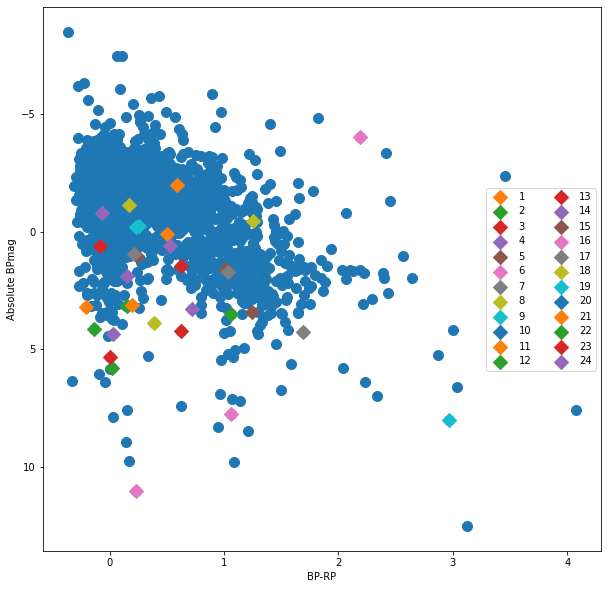

In [17]:
# marking questionable gaia counterparts of BeSS stars with multiple matches using conf_flag_gaia column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots


fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(df_gaia_comb['BP-RP'], df_gaia_comb['abs_BPmag'], s=100)

j=1
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances == 1:
        pass
    else:
        ax.scatter(df_sub['BP-RP'], df_sub['abs_BPmag'], s=100, marker='D',label=j)
        #print(j, df_sub[['_q','_r_x','Source','_RAJ2000','_DEJ2000','BP-RP','abs_BPmag']])
        j += 1
        
plt.legend(ncol=2)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('Absolute BPmag')

In [18]:
# We take the closest counterparts for those questionable.multiple gaia counterparts 
 
df_gaia = find_nearest(df_gaia_comb, ind_col='_q', sep_col='_r')


Before cleaning multiple matches: 2190 rows.
After cleaning multiple matches: 2164 rows.


In [19]:
Counter(df_gaia['gaia_conf'])

Counter({0.0: 1940, 1.0: 165, 2.0: 35, 4.0: 15, 6.0: 9})

In [20]:
# Combining BeSS catalog and gaia catalog 

df_BeSS = BeSS.to_pandas()
df_comb = pd.merge(df_BeSS[['#','Be star','_RAJ2000', '_DEJ2000','V','Type','conf_flag']], df_gaia.drop(columns=['_q_y','_r_y','_q_dr3', '_r_dr3']), left_on="#", right_on="_q", how="outer")
print(df_comb.columns)

Index(['#', 'Be star', '_RAJ2000', '_DEJ2000', 'V', 'Type', 'conf_flag', '_q',
       'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'RPlx', 'pmRA',
       'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag', 'BPmag', 'RPmag', 'Teff',
       'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'Flag',
       'Pstar', 'SpType-ELS', 'BP-RP', 'abs_BPmag', 'gaia_conf'],
      dtype='object')


In [21]:
# Using gaia coordinates rather than BeSS coordinates, unless there is no gaia match for BeSS stars
df_comb['RA'], df_comb['DEC'] = df_comb['RA_ICRS'], df_comb['DE_ICRS']
df_comb.loc[df_comb['RA'].isnull(), 'RA'] = df_comb.loc[df_comb['RA'].isnull(), '_RAJ2000']
df_comb.loc[df_comb['DEC'].isnull(), 'DEC'] = df_comb.loc[df_comb['DEC'].isnull(), '_DEJ2000']

df_comb.to_csv('./catalogs/BeSS2Gaia.csv',index=False)

In [22]:
BeSS = ascii_io.read("./catalogs/BeSS2Gaia.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'deg').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
BeSS.pprint()

 #    Be star       _RAJ2000    ... gaia_conf        RA             DEC      
                      deg       ...                                          
---- ---------- --------------- ... --------- --------------- ---------------
   1 BD+62 2346   0.35290298355 ...       0.0   0.35290298355  63.50434766899
   2  HD 224905   0.41094910628 ...       0.0   0.41094910628  60.44991724112
   3  HD 225095   0.86309820655 ...       0.0   0.86309820655  55.55089167635
   4      2 Cet   0.93506738484 ...       0.0   0.93506738484 -17.33603138528
   5     10 Cas   1.61066661509 ...       0.0   1.61066661509  64.19616165053
   6 BD+59 2829   1.70124274523 ...       0.0   1.70124274523  60.60022812302
 ...        ...             ... ...       ...             ...             ...
2258   V818 Cas 357.47128496186 ...       0.0 357.47128496186  62.21408032819
2259 EM* AS 518 359.38364207767 ...       0.0 359.38364207767  72.88434818677
2260 BD+65 1970 359.39205872406 ...       1.0 359.39205872406  6

# forward-matching to X-ray catalogs

In [23]:
# XRT conversion Gamma=2 if not available
# XMM why apply absorption to get the observed flux
# Gamma=1.7 for other conversion if not available
# XRT conversion twice 
# how do we deal with 0 and null flux
# do we want to include uncertainties
# use MC to calculate uncertainties

In [24]:
# matching to X-ray catalogs, for 2SXPS we use the 2sxps version rather than 2sxpscle clean version

cat_ids = ["IX/57/csc2master","IX/65/xmm4d11s","IX/58/2sxps"] 
Xmatch = [None, None, None]
radii = ["2s","5s","9s"]
for i in range(len(cat_ids)):
    Xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[CSC_xmatch, XMM_xmatch, XRT_xmatch] = Xmatch

Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/65/xmm4d11s
Successfully matched BeSS with IX/58/2sxps


In [25]:
Chandra_sources = CSC_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","r0","_2CXO","S_N", 'HRhm', 'HRhs', 'HRms',
                                'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs',
                                'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL'].to_pandas()
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","ePos","_4XMM",'srcML','Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4'].to_pandas()
xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))

XRT_sources = XRT_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","Err90",'_2SXPS','Det', 'CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'E_FPO0','e_FPO0','FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'].to_pandas()


In [26]:
# checking the multiple matches from X-ray catalogs 
for df in [Chandra_sources, XMM_sources, XRT_sources]:

    print(df[df.duplicated(subset=['_q'], keep=False)])
    

      _q     _r    _RAJ2000   _DEJ2000     r0              _2CXO     S_N  \
37   892  0.834   84.727452  26.315550  1.403  J053854.5+261855X  27.094   
38   892  0.198   84.727417  26.315725  0.710   J053854.5+261856  89.197   
45  1376  1.084  161.473743 -59.951355  0.721   J104553.6-595704  16.614   
46  1376  0.069  161.473733 -59.951072  0.721   J104553.6-595703   4.158   
50  1456  0.321  172.778935 -62.946932  0.713   J113106.9-625648  20.855   
51  1456  0.885  172.779145 -62.946756  2.002  J113106.9-625648X  13.580   

       HRhm     HRhs     HRms  ...         Fluxs       B_Fluxs       b_Fluxs  \
37      NaN      NaN      NaN  ...           NaN           NaN           NaN   
38  0.58339  0.77327  0.34603  ...  6.522526e-14  6.806354e-14  6.238699e-14   
45      NaN      NaN      NaN  ...  0.000000e+00  2.921220e-15  0.000000e+00   
46  0.18988 -0.24110 -0.40350  ...  2.094771e-15  2.894592e-15  1.256862e-15   
50  0.67208  0.93067  0.68582  ...  1.292182e-14  1.748246e-14  8.1

In [27]:
# taking the closest counterpart
df_CSC = find_nearest(Chandra_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XMM = find_nearest(XMM_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XRT = find_nearest(XRT_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)

Before cleaning multiple matches: 83 rows.
After cleaning multiple matches: 80 rows.
Before cleaning multiple matches: 127 rows.
After cleaning multiple matches: 125 rows.
Before cleaning multiple matches: 94 rows.
After cleaning multiple matches: 92 rows.


In [28]:
# merging X-ray catalog matching results

xray = pd.merge(df_CSC, df_XMM, on="_q", how="outer")
xray = pd.merge(xray, df_XRT, on="_q", how="outer")

print(len(xray))

185


In [29]:
xray.columns

Index(['_q', '_r_x', '_RAJ2000_x', '_DEJ2000_x', 'r0', '_2CXO', 'S_N', 'HRhm',
       'HRhs', 'HRms', 'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm',
       'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu',
       'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL', '_r_y', '_RAJ2000_y',
       '_DEJ2000_y', 'ePos', '_4XMM', 'srcML', 'Flux1', 'e_Flux1', 'Flux2',
       'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5', 'e_Flux5',
       'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1_x', 'e_HR1', 'HR2_x',
       'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_r', '_RAJ2000', '_DEJ2000',
       'Err90', '_2SXPS', 'Det', 'CR0', 'E_CR0', 'e_CR0', 'HR1_y', 'HR2_y',
       'CR1', 'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3',
       'PcstS0', 'FPO0', 'E_FPO0', 'e_FPO0', 'FPU0', 'Gam1', 'E_Gam1',
       'e_Gam1'],
      dtype='object')

In [30]:
# renaming some columns 

xray.rename(columns={'_r_x':'_r_CSC','_RAJ2000_x':'_RAJ2000_CSC','_DEJ2000_x':'_DEJ2000_CSC',
                     '_r_y':'_r_XMM','_RAJ2000_y':'_RAJ2000_XMM','_DEJ2000_y':'_DEJ2000_XMM',
                     '_r':'_r_XRT','_RAJ2000':'_RAJ2000_XRT','_DEJ2000':'_DEJ2000_XRT',"HR1_x":"HR1","HR2_x":"HR2","HR1_y":"SwiftHR1","HR2_y":"SwiftHR2"},inplace=True)

print(xray.columns)

Index(['_q', '_r_CSC', '_RAJ2000_CSC', '_DEJ2000_CSC', 'r0', '_2CXO', 'S_N',
       'HRhm', 'HRhs', 'HRms', 'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm',
       'B_Fluxm', 'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu',
       'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL', '_r_XMM',
       '_RAJ2000_XMM', '_DEJ2000_XMM', 'ePos', '_4XMM', 'srcML', 'Flux1',
       'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4',
       'Flux5', 'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1',
       'e_HR1', 'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_r_XRT',
       '_RAJ2000_XRT', '_DEJ2000_XRT', 'Err90', '_2SXPS', 'Det', 'CR0',
       'E_CR0', 'e_CR0', 'SwiftHR1', 'SwiftHR2', 'CR1', 'e_CR1', 'CR2',
       'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0', 'FPO0', 'E_FPO0',
       'e_FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'],
      dtype='object')


In [31]:
def bandshift(fluxA,bandA,bandB,Gamma=1.7):
    a1,a2 = bandA
    b1,b2 = bandB
    if Gamma == 2:
        integral = lambda lower,upper : np.log(upper) - np.log(lower)
    else:
        integral = lambda lower,upper : (upper**(2-Gamma) - lower**(2-Gamma))/(2-Gamma)
    scalar = fluxA/integral(a1,a2)
    fluxB = scalar*integral(b1,b2)
    return fluxB

In [32]:
CSC_fluxs = ['Fluxs', 'Fluxm', 'Fluxh']
XMM_fluxs = ['Flux1', 'Flux2', 'Flux3', 'Flux4', 'Flux5']
XRT_fluxs = ['FPO0']

for i,row in xray.iterrows():
    flag = []
    if pd.notna(row["_2CXO"]):
        flag.append("CXO")
    if pd.notna(row["_4XMM"]):
        flag.append("XMM")
    if pd.notna(row["_2SXPS"]):
        flag.append("XRT")
    flag = "+".join(flag)
    if len(flag)<3:
        flag = np.nan
    xray.loc[i,"Flag"] = flag

xray.dropna(subset=["Flag"],inplace=True)
    
xray["Flux45"] = xray.Flux4 + xray.Flux5

#xray = xray.replace(0,1e-19)

xray["Flag"].value_counts()

XMM            55
CXO+XMM+XRT    33
XRT            29
CXO            22
XMM+XRT        21
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64

In [33]:
xray['X_pos'] = 'CXO'
xray['_RAJ2000_X'] = xray['_RAJ2000_CSC']
xray['_DEJ2000_X'] = xray['_DEJ2000_CSC']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XMM'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XMM'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XMM']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XRT'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XRT'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XRT']


In [34]:
xray["N_H"] = GasMap.nh(SkyCoord(xray["_RAJ2000_X"], xray["_DEJ2000_X"], unit = 'deg'), nhmap='LAB').value

# Correct absorption

https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl

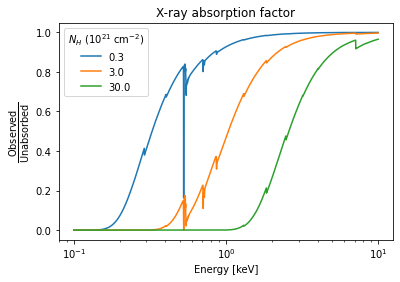

In [35]:
# tbabs from xspec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('./tbabs.data', skiprows=0)
# tbabs_cross # table is in units of 1e22 cm^2, we want to work in 1e24

for nH in [3e20,3e21,3e22]:
    plt.plot(tbabs_ene, np.exp(-nH/1e22 * tbabs_cross),label=nH/1e21)
plt.xscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel(r"$\frac{\mathrm{Observed}}{\mathrm{Unabsorbed}}$", size=14)
plt.legend(title="$N_H\ (10^{21}\ \mathrm{cm}^{-2})$")
plt.title("X-ray absorption factor")
plt.show()

In [36]:
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

def red_factor(ene, nH, Gamma, tbabs_ene, tbabs_cross): # energy in keV, nH in cm^-2

    if Gamma == 2:
        flux_unred_int = np.log(ene[1]) - np.log(ene[0])
    else:
        flux_unred_int   = (ene[1]**(2.-Gamma)-ene[0]**(2.-Gamma))/(2.-Gamma)
        
    _ = tbabs_ene**(1 - Gamma) # pseudo spectrum
    tbabs_flux_red = _ * np.exp(-nH/1e22 * tbabs_cross) # extincted spectrum
    
    finterp = InterpolatedUnivariateSpline(tbabs_ene, tbabs_flux_red, k=1)
    
    flux_red_int = finterp.integral(*ene)

    return flux_red_int / flux_unred_int

In [37]:
bands = [(0.2,1),(1,2),(2,10)]
print("Assuming nH = 3e20 and Gamma = 1.7:")
for enes in bands:
    print(f"In the {enes[0]:.1f}-{enes[1]:.1f} keV band we lose {1-red_factor(enes,3e20,1.7,tbabs_ene,tbabs_cross):.1%} of flux due to absorption")

Assuming nH = 3e20 and Gamma = 1.7:
In the 0.2-1.0 keV band we lose 33.9% of flux due to absorption
In the 1.0-2.0 keV band we lose 3.4% of flux due to absorption
In the 2.0-10.0 keV band we lose 0.3% of flux due to absorption


In [38]:
bands = [(0.2,1),(1,2),(2,10)]
print("Assuming nH = 3e20 and Gamma = 1.7:")
for enes in bands:
    print(f"In the {enes[0]:.1f}-{enes[1]:.1f} keV band we retain: {red_factor(enes,3e20,1.7,tbabs_ene,tbabs_cross):.1%}")

Assuming nH = 3e20 and Gamma = 1.7:
In the 0.2-1.0 keV band we retain: 66.1%
In the 1.0-2.0 keV band we retain: 96.6%
In the 2.0-10.0 keV band we retain: 99.7%


In [39]:
xray.columns

Index(['_q', '_r_CSC', '_RAJ2000_CSC', '_DEJ2000_CSC', 'r0', '_2CXO', 'S_N',
       'HRhm', 'HRhs', 'HRms', 'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm',
       'B_Fluxm', 'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu',
       'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL', '_r_XMM',
       '_RAJ2000_XMM', '_DEJ2000_XMM', 'ePos', '_4XMM', 'srcML', 'Flux1',
       'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4',
       'Flux5', 'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1',
       'e_HR1', 'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_r_XRT',
       '_RAJ2000_XRT', '_DEJ2000_XRT', 'Err90', '_2SXPS', 'Det', 'CR0',
       'E_CR0', 'e_CR0', 'SwiftHR1', 'SwiftHR2', 'CR1', 'e_CR1', 'CR2',
       'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0', 'FPO0', 'E_FPO0',
       'e_FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1', 'Flag', 'Flux45', 'X_pos',
       '_RAJ2000_X', '_DEJ2000_X', 'N_H'],
      dtype='object')

In [40]:
bands = [(0.2,1),(1,2)]
for i,row in xray[xray["Flux2"].notna() & xray["Flux3"].notna() & xray["Flux45"].notna()].iterrows():
    fluxs = row[["Flux2","Flux3"]].values
    reabsorbed = [flux*red_factor(enes,3e20,1.7,tbabs_ene,tbabs_cross) for flux,enes in zip(fluxs,bands)]
#     if pd.notna(row["GamPL"]):
#         gam = row["GamPL"]
#     elif pd.notna(row["Gam1"]):
#         gam = row["Gam1"]
#     else:
#         gam = 2
#     NH = row["N_H"]
#     reabsorbed = [flux*red_factor(enes,NH,gam,tbabs_ene,tbabs_cross) for flux,enes in zip(unabs,bands)]
    xray.loc[i,["Flux2","Flux3"]] = reabsorbed

# Translate X-ray fluxes

In [41]:
# Determining X-ray fluxes at CXO s,m,h bands in priority of CSC -> XMM -> XRT
# X_pos and X_flux are not necessarily coming from the same X-ray catalog since some X-ray catalog has the valid coordinate but the fluxes might be Null
for i in xray[xray["_2CXO"].notna() | xray["_4XMM"].notna() | xray["_2SXPS"].notna()].index:
    
    cxoflux, xmmflux, xrtflux = xray.loc[i,CSC_fluxs].values, xray.loc[i,XMM_fluxs].values, xray.loc[i,XRT_fluxs].values
    exists = False
    
    if pd.notna(xray.loc[i,"GamPL"]): # spectral index from Chandra
        GamPL = float(xray.loc[i,"GamPL"])
        Gamma = AsymmetricUncertainty(GamPL,xray.loc[i,"B_GamPL"]-GamPL,GamPL-xray.loc[i,"b_GamPL"])
        exists = True
    elif pd.notna(xray.loc[i,"Gam1"]): # spectral index from Swift
        Gam1 = float(xray.loc[i,"Gam1"])
        Gamma = AsymmetricUncertainty(Gam1,xray.loc[i,"E_Gam1"],xray.loc[i,"e_Gam1"])
        exists = True
    else: # assumption for general case
        Gamma = 1.7
    
    if all(pd.notna(cxoflux)): # good Chandra observations present
        pos_err = xray.loc[i,["B_Fluxs","B_Fluxm","B_Fluxh"]] - cxoflux
        neg_err = cxoflux - xray.loc[i,["b_Fluxs","b_Fluxm","b_Fluxh"]]
        converted = []
        for j in range(3):
            if cxoflux[j] == neg_err[j] == 0: # upper limt
                converted.append(AsymmetricUncertainty(pos_err[j],0,np.inf))
            else: # regular detection
                converted.append(AsymmetricUncertainty(cxoflux[j],pos_err[j],neg_err[j]))
        source = "CXO"
        
    elif all(pd.notna(xmmflux)): # no Chandra, but good XMM
        xmmerr = xray.loc[i,["e_"+band for band in XMM_fluxs]]
        mergedxmm = np.array([AsymmetricUncertainty(xmmflux[1],xmmerr[1],xmmerr[1]),
                              AsymmetricUncertainty(xmmflux[2],xmmerr[2],xmmerr[2]),
                              AsymmetricUncertainty(xmmflux[3],xmmerr[3],xmmerr[3])+AsymmetricUncertainty(xmmflux[4],xmmerr[4],xmmerr[4])])
        origbands = [(0.2,1),(1,2),(2,12)]
        converted = [bandshift(flux,xmmband,cxoband,Gamma) for flux,xmmband,cxoband in
                     zip(mergedxmm,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XMM"
        
    elif all(pd.notna(xrtflux)): # neither Chandra nor XMM, but good Swift-XRT
        #print(xrtflux)
        pos_err = xray.loc[i,"E_FPO0"]
        neg_err = xray.loc[i,"e_FPO0"]
        origbands = [(0.3,10),(0.3,10),(0.3,10)]
        converted = [bandshift(flux,xrtband,cxoband,Gamma) for flux,xrtband,cxoband in
                     zip([AsymmetricUncertainty(xrtflux,pos_err,neg_err)]*3,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        #[ print(flux,xrtband,cxoband) for flux,xrtband,cxoband in
                     #zip([xrtflux]*3,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        #print(converted)
        source = "XRT"
        
    else:
        converted = np.nan
        source = np.nan
        continue
    
    
    for j,b in enumerate("smh"):
        xray.loc[i,f"Flux ({b} band)"] = converted[j]
    
    xray.loc[i,"X_flux"] = source
    if exists:
        xray.loc[i,"Gamma"] = Gamma
        
# xray = xray[['_q', '_2CXO', '_4XMM', '_2SXPS', 'Flag', '_RAJ2000_X', '_DEJ2000_X', 'Flux (s band)', 'Flux (m band)', 'Flux (h band)', 'X_flux', 'Gamma',
#              'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu',
#              'Flux1', 'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5', 'e_Flux5']]

In [42]:
#print(xray.columns)
# dropping those with invalid X-ray fluxes
print("dropping:")
xray.loc[xray["X_flux"].isna(), ['_q', '_2CXO',  'Flag', '_RAJ2000_X', '_DEJ2000_X',
                                 'Flux (s band)', 'Flux (m band)', 'Flux (h band)', 'X_flux', 'Gamma']]
xray = xray.dropna(subset=['X_flux']).reset_index(drop=True)

dropping:


In [43]:
print(xray[['X_flux']].value_counts())

X_flux
XMM       80
CXO       72
XRT       29
dtype: int64


43


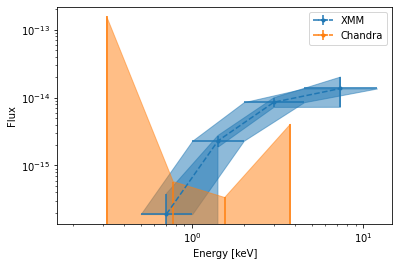

48


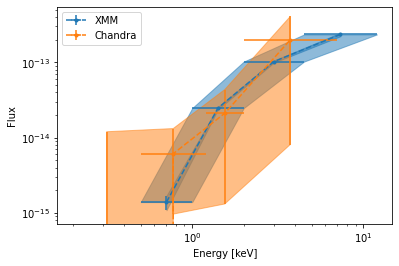

50


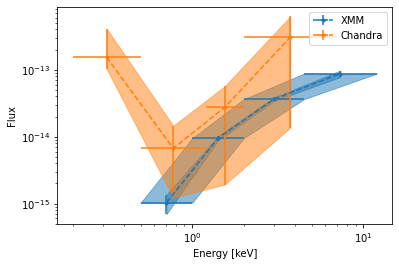

52


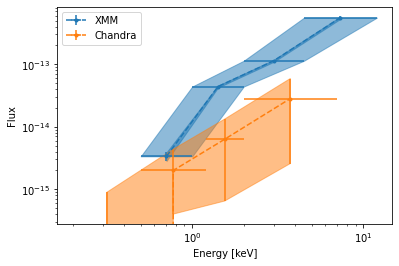

60


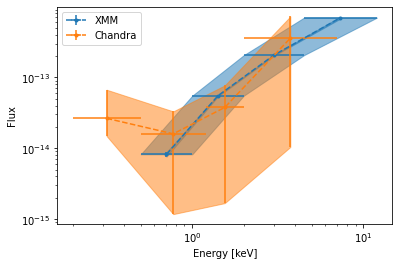

66


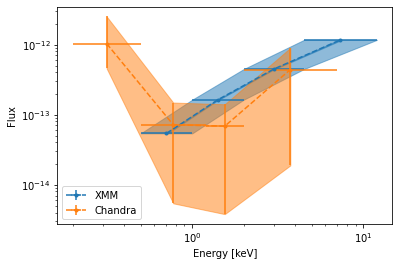

67


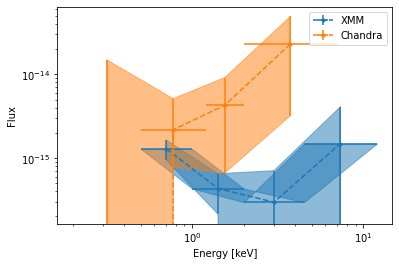

69


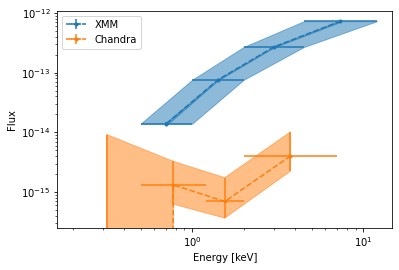

71


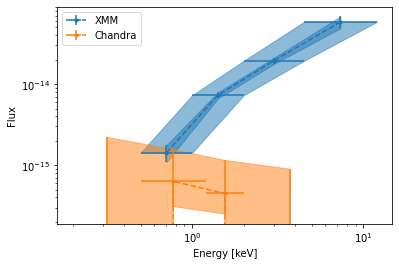

82


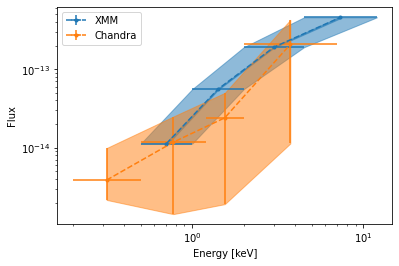

92


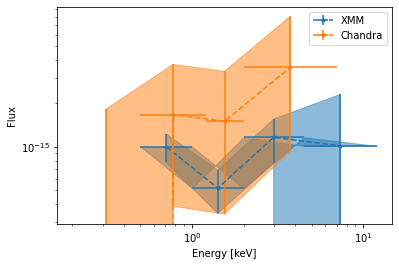

117


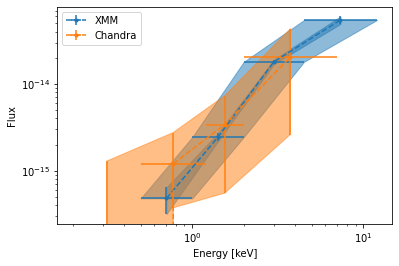

140


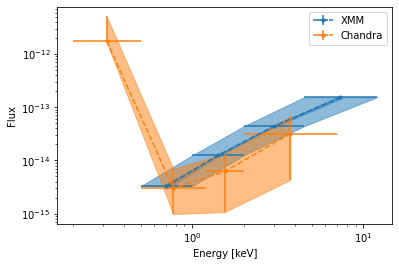

164


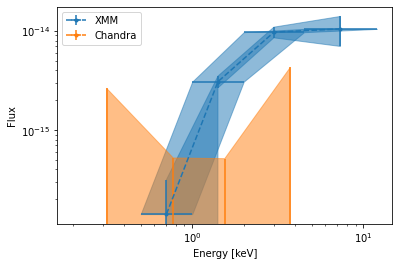

231


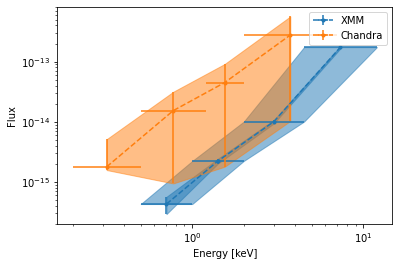

254


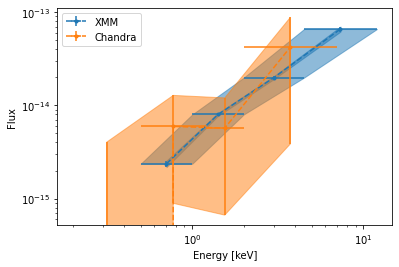

258


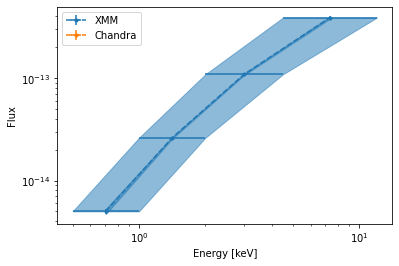

261


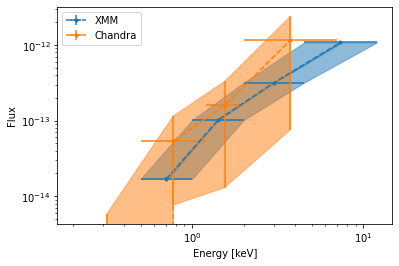

266


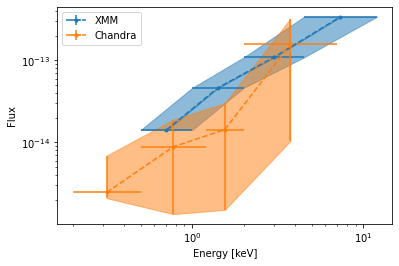

271


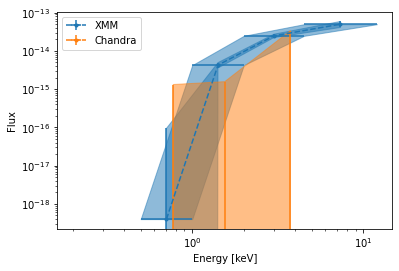

273


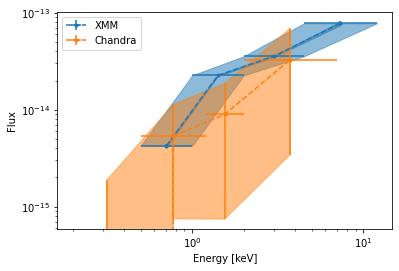

275


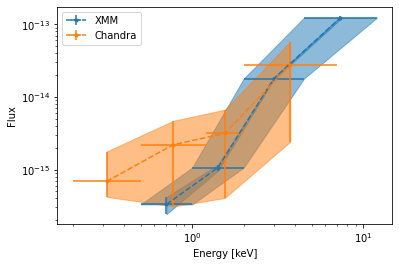

517


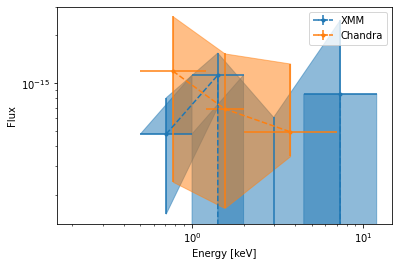

597


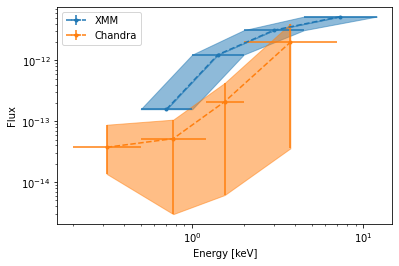

682


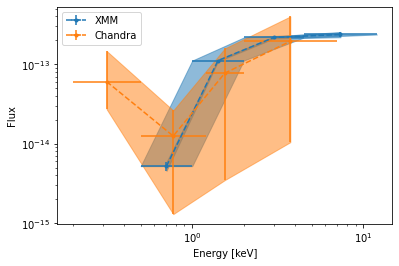

688


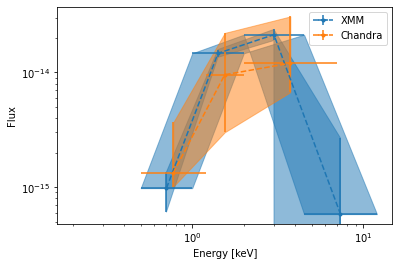

758


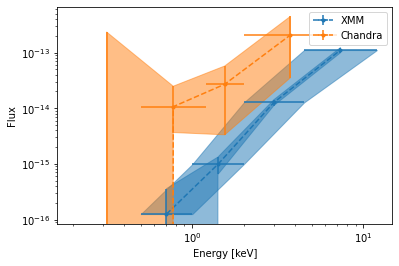

772


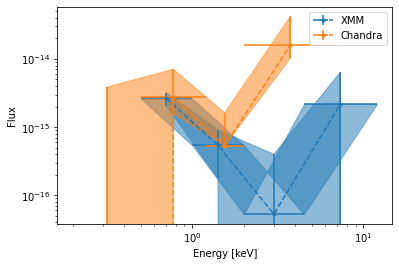

856


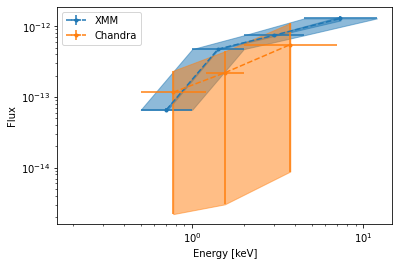

857


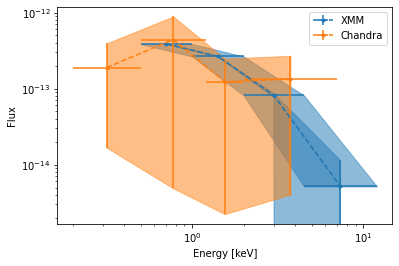

892


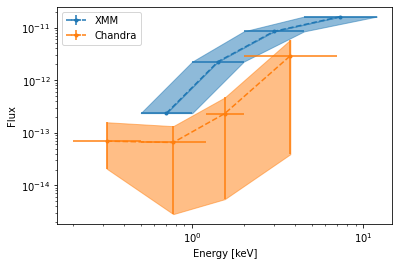

1001


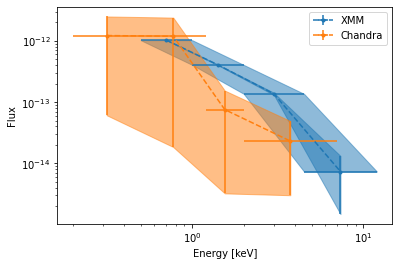

1168


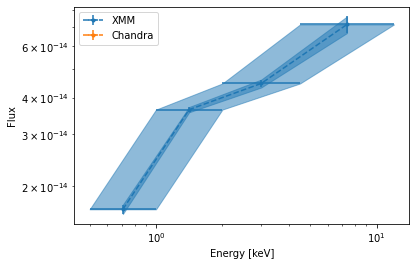

1563


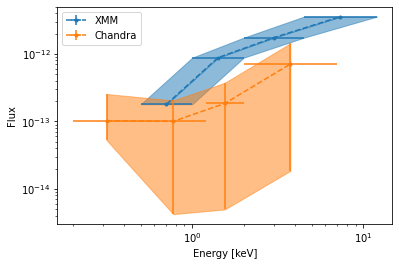

1601


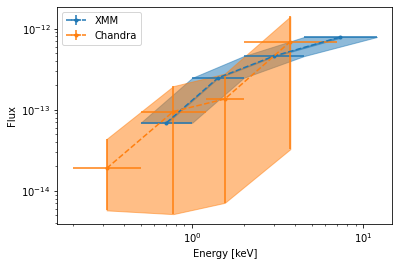

1851


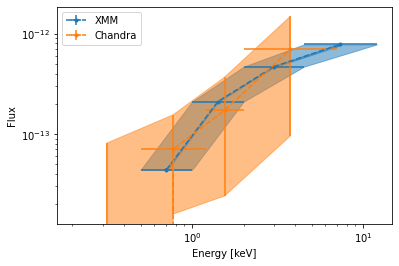

1858


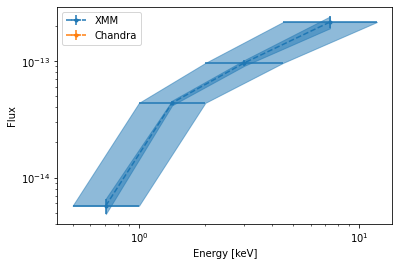

1868


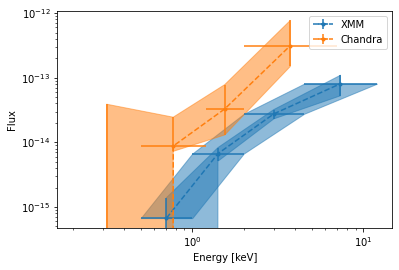

1875


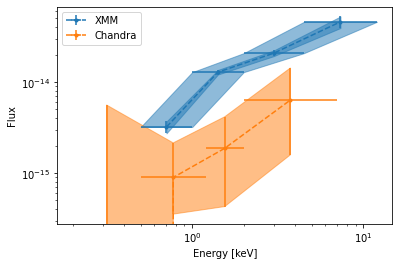

1887


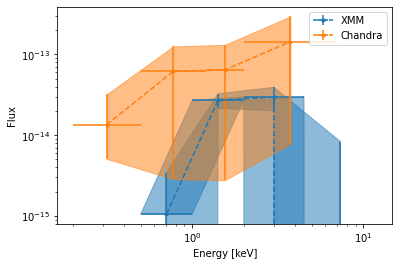

1891


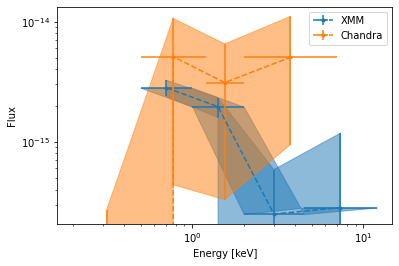

1893


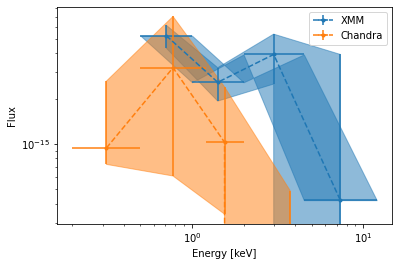

1895


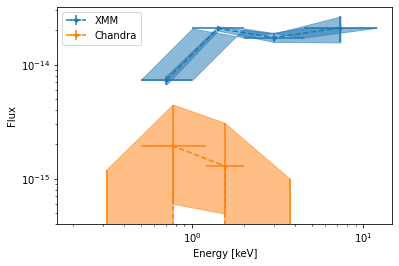

1896


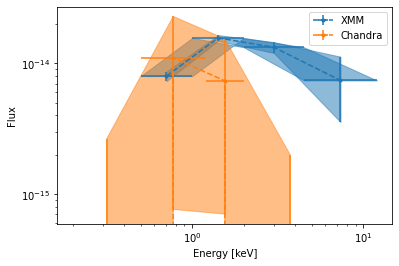

1900


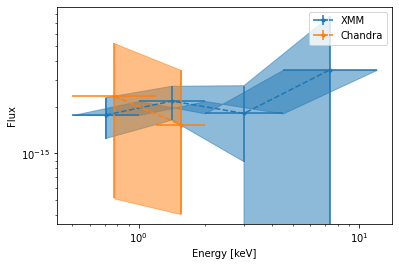

1903


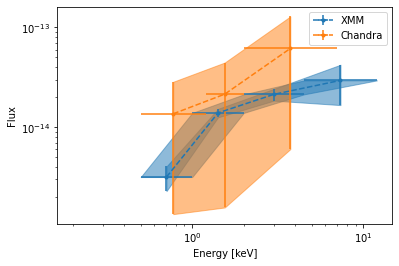

1930


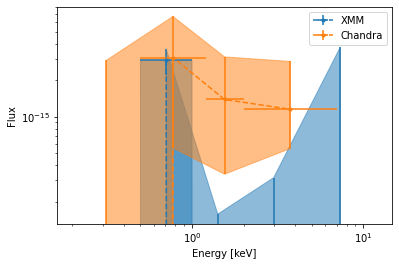

1931


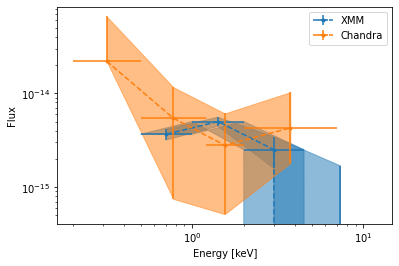

2123


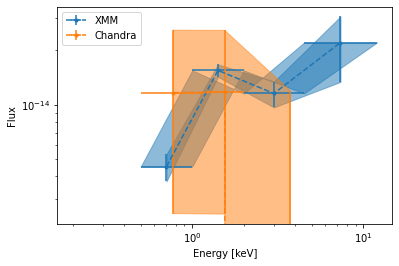

In [44]:
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))
xmm_E = np.array([log_mean(0.5,1),log_mean(1,2),log_mean(2,4.5),log_mean(4.5,12)])
cxo_E = np.array([log_mean(0.2,0.5),log_mean(0.5,1.2),log_mean(1.2,2),log_mean(2,7)])
for idx,obj in xray[xray["_2CXO"].notna() & xray["_4XMM"].notna()].iterrows():
    obj = obj.replace(1.0e-17,np.nan)
#     obj = obj.replace(0,np.nan)
    print(int(obj["_q"]))
    plt.errorbar(xmm_E,obj[["Flux2","Flux3","Flux4","Flux5"]],
                 xerr=[xmm_E-np.array([0.5,1,2,4.5]), np.array([1,2,4.5,12])-xmm_E],
                 yerr=obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]],
                 linestyle="--",marker=".",label="XMM")
    lower = obj[["Flux2","Flux3","Flux4","Flux5"]].values - obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    upper = obj[["Flux2","Flux3","Flux4","Flux5"]].values + obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    plt.fill_between(xmm_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C0",alpha=0.5)
    plt.fill_betweenx(np.array(obj[["Flux2","Flux3","Flux4","Flux5"]].values,dtype=float),[0.5,1,2,4.5],[1,2,4.5,12],
                      color="C0",alpha=0.5)
    plt.errorbar(cxo_E,obj[["Fluxu","Fluxs","Fluxm","Fluxh"]],
                 xerr=[cxo_E-np.array([0.2,0.5,1.2,2]), np.array([0.5,1.2,2,7])-cxo_E],
                 yerr=[obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]],
                       obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]]],
                 linestyle="--",marker=".",label="Chandra")
    lower = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values - obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]].values
    upper = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values + obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]].values
    plt.fill_between(cxo_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C1",alpha=0.5)
    
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Energy [keV]")
    plt.ylabel("Flux")
    plt.show()

# backward-matching with gaia counterparts of X-ray sources

In [45]:

# matching to gaiaedr3
v = Vizier(columns=['all', 'DR3Name','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

radec = [[xray.loc[j,'_RAJ2000_X'], xray.loc[j, '_DEJ2000_X']] for j in range(len(xray))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

X_ga = v.query_region(rd, catalog="I/355/gaiadr3", radius='9s')[0]
X_ga['Source'] = X_ga['Source'].astype(str)
X_ga = X_ga.to_pandas()
#print(len(X_ga))

#X_ga['Source'] = X_ga.apply(lambda row: np.int64(row.DR3Name[10:]), axis=1)
X_ga = find_nearest(X_ga, ind_col='Source', sep_col='_r', check=False, drop=False)
print(len(X_ga))
# matching to gaiaedr3dist
v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

X_gaiadist = v.query_region(rd, catalog="I/352/gedr3dis", radius='9s')[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]
X_gaiadist['Source'] = X_gaiadist['Source'].astype(str)
X_gaiadist = X_gaiadist.to_pandas()
#print(len(X_gaiadist))
X_gaiadist = find_nearest(X_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)
#print(len(X_gaiadist))
X_gaia = pd.merge(X_ga, X_gaiadist, on='Source', how="outer")
print(len(X_gaia))


v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

X_gapar = v.query_region(rd, catalog="I/355/paramp", radius="9s")[0]["_q","_r","Source","Pstar","SpType-ELS"]

X_gapar['Source'] = X_gapar['Source'].astype(str)
X_gapar = X_gapar.to_pandas()
#print(len(X_gapar))
#gaiaparamp_df = gaiaparamp_df.rename(columns={'Source':'Source2'})
X_gapar = find_nearest(X_gapar, ind_col='Source', sep_col='_r', check=False, drop=False)
#print(len(X_gapar))

#print(X_gapar.loc[~(X_gapar.Source.isin(X_gaia.Source)), '_r'])
X_gaia = pd.merge(X_gaia, X_gapar, on='Source', how="outer")
print(len(X_gaia))
#print(X_ga.columns[:30])

X_gaia['BP-RP'] = X_gaia['BPmag']-X_gaia['RPmag']
X_gaia['abs_BPmag'] = X_gaia['BPmag']-5*(np.log10(X_gaia['rgeo'])-1)
X_gaia['_q'] = X_gaia['_q_x']
X_gaia['_r'] = X_gaia['_r_x']

Before cleaning multiple matches: 1139 rows.
After cleaning multiple matches: 1135 rows.
1135
Before cleaning multiple matches: 867 rows.
After cleaning multiple matches: 863 rows.
1135
Before cleaning multiple matches: 803 rows.
After cleaning multiple matches: 799 rows.
1135


In [46]:
print(xray['X_pos'].value_counts())
xray['X_pos']
print(xray["Flag"].value_counts())

#print(xray[xray.X_pos=='CXO'])

CXO    76
XMM    76
XRT    29
Name: X_pos, dtype: int64
XMM            55
CXO+XMM+XRT    33
XRT            29
XMM+XRT        21
CXO            18
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64


In [47]:
# cleaning matches outside corresponding X-ray error circles since I used 9" for all matches for convenience

print('Before cleaning matches outside X-ray error circles:',len(X_gaia))  

search_radii = {'CXO': 2, 'XMM':5, 'XRT':9}

for i in X_gaia['_q'].unique():
    
    drop_idx = X_gaia[(X_gaia['_q'] == i) & (X_gaia['_r'] > search_radii[xray.loc[i-1, 'X_pos']] ) ].index

    X_gaia.drop(drop_idx, inplace = True)


print('After cleaning matches outside X-ray error circles:',len(X_gaia))

Before cleaning matches outside X-ray error circles: 1135
After cleaning matches outside X-ray error circles: 481


In [48]:
df_BeSS

#     Be star   Category           RA           DEC       V  \
0        1  BD+62 2346  Classical  00 01 24.70   63 30 15.73   9.730   
1        2   HD 224905  Classical  00 01 38.63   60 26 59.72   8.470   
2        3   HD 225095  Classical  00 03 27.15   55 33 03.23   7.950   
3        4       2 Cet  Classical  00 03 44.39  -17 20 09.57   4.543   
4        5      10 Cas  Classical  00 06 26.54   64 11 46.21   5.567   
...    ...         ...        ...          ...           ...     ...   
2259  2260  BD+65 1970  Classical  23 57 34.10   66 25 53.84  10.170   
2260  2261      LQ And  Classical  23 58 46.44   46 24 47.44   6.542   
2261  2262   HD 224544  Classical  23 58 49.24   32 22 54.14   6.524   
2262  2263   HD 224599  Classical  23 59 14.97   60 01 20.93   9.700   
2263  2264     eps Tuc  Classical  23 59 54.98  -65 34 37.68   4.490   

           Type  vsini  Nb of spectra in BeSS    _RAJ2000   _DEJ2000  \
0          B0Ve   <NA>                      3    0.352917  63.504369   
1         B1Vne   <NA>                     85    0.410958  60.449922   
2        B2IVne   <NA>                    234    0.863125  55.550897   
3        B9IVne   <NA>                     95    0.934958 -17.335992   
4        B9IIIe    125                    292    1.610583  64.196169   
...         ...    ...                    ...         ...        ...   
2259        B5e   <NA>                      1  359.392083  66.431622   
2260      B4Vne    300                    507  359.693500  46.413178   
2261      B6IVe    260                    402  359.705167  32.381706   
2262  B0.5Vnnpe   <NA>                      2  359.812375  60.022481   
2263       B8Ve    300                     14  359.979083 -65.577133   

      conf_flag  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
2259          0  
2260          0  
2261          0  
2262          0  
2263          0  

[2264 rows x 12 columns]


indexs =    [68,        42,         47,         49,         230,       237,        253,      272,       274,        260,      296,     1630]

gaia_ras =  [13.02345,   12.142170,  12.306773,  12.374212,  14.400078,14.552446,  15.262034,16.290251, 16.480222,  15.467899,19.633210,215.300650]
gaia_decs = [-72.434514, -73.042030, -73.193853, -73.182921, -72.326132,-72.513544,-72.116379,-72.196375,-72.064044,-72.392790,63.742520,-62.698914]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    #print(BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'])
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'] = ra, dec 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])
    
BeSS['conf_flag'] = 0

indexs =    [760,      767,      150,       215,            516,      857,       1410,           1478,      1604,          2074,      189,          1715,      1930,      139,      1375,            857,            1475,             79,          120,         226,              265,                   1243,           1331,        1574,     1926]

gaia_ras =  [80.124405,80.691452,13.957651, 14.16150651198, 34.809579,83.920304, 165.62489467958,174.7414595,207.402686,   303.73052859,14.08276055767,241.011158,274.692197,13.896433, 161.47374583153,83.92084433997, 174.58301532056,13.34460251277,13.72732352852,14.29036126271,15.9064071959,       133.34164824874,156.50072742424,198.54794100157,274.63838149679]
gaia_decs = [-69.532146,33.416338,-72.452880,-72.30366663757,57.184698,-66.864928,-60.81551722574,-63.4774941368,-42.473011,36.8535390968,-72.46714301601,-47.477649,-13.910324,-72.485176, -59.95105371342,-66.86487936541,-63.34347837499,-72.19883641895,-72.45661959811,-72.44935286279,-72.02589539658,-46.03576523452,-57.82691748014,-63.37375307540,-13.75223648534]

for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])


    _RAJ2000_X  _DEJ2000_X X_pos
77   13.955317  -72.452594   XMM
       #           Be star   _RAJ2000  _DEJ2000
150  151  Cl* NGC 330 G 68  13.957651 -72.45288
    _RAJ2000_X  _DEJ2000_X X_pos
78   14.158752  -72.302808   XMM
       #                 Be star   _RAJ2000   _DEJ2000
215  216  Cl* NGC 330 ELS 004509  14.161507 -72.303667
     _RAJ2000_X  _DEJ2000_X X_pos
112  165.625379   -60.81516   XMM
         #    Be star    _RAJ2000   _DEJ2000
1410  1411  HD 305891  165.624895 -60.815517
     _RAJ2000_X  _DEJ2000_X X_pos
113  174.582971  -63.342137   XMM
         #   Be star    _RAJ2000   _DEJ2000
1475  1476  V870 Cen  174.583015 -63.343478
     _RAJ2000_X  _DEJ2000_X X_pos
114  174.743643   -63.47744   XMM
         #    Be star    _RAJ2000   _DEJ2000
1478  1479  HD 308829  174.741459 -63.477494
     _RAJ2000_X  _DEJ2000_X X_pos
140  303.730911   36.853153   XMM
         #    Be star    _RAJ2000   _DEJ2000
2074  2075  HD 228535  303.730529  36.853539
     _RAJ2000_X  _DEJ2000_X X_po

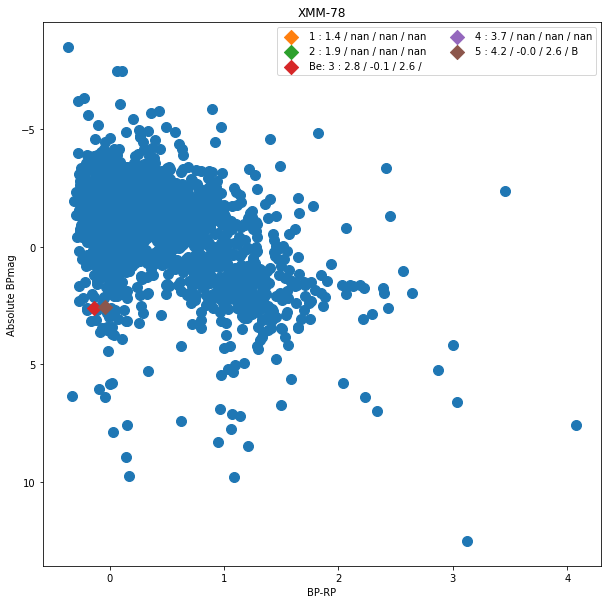

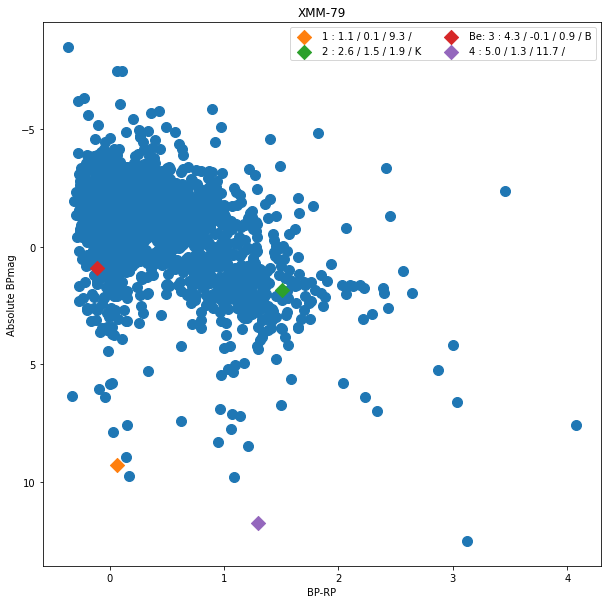

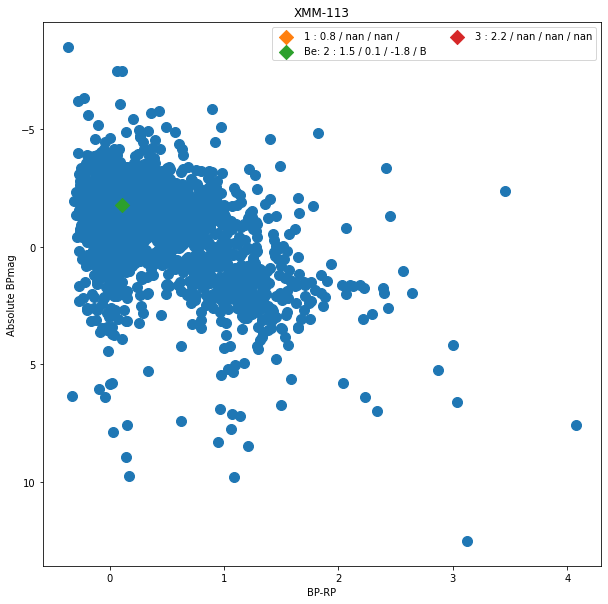

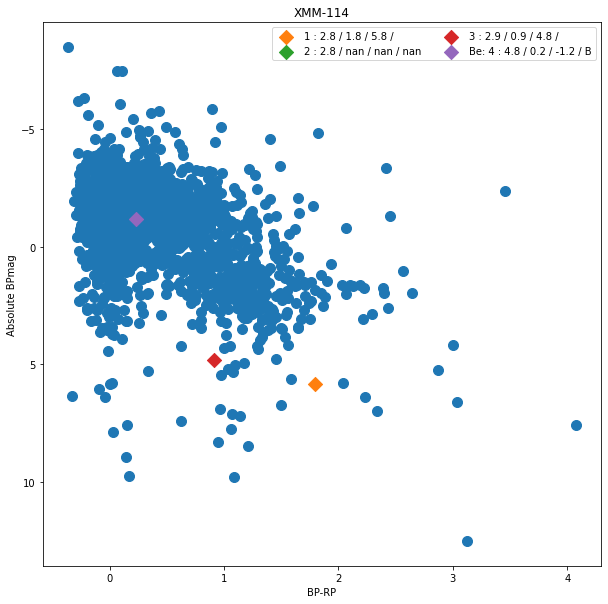

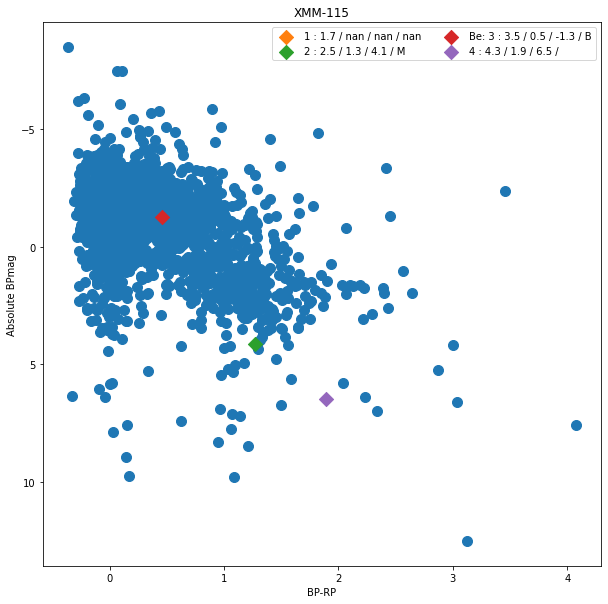

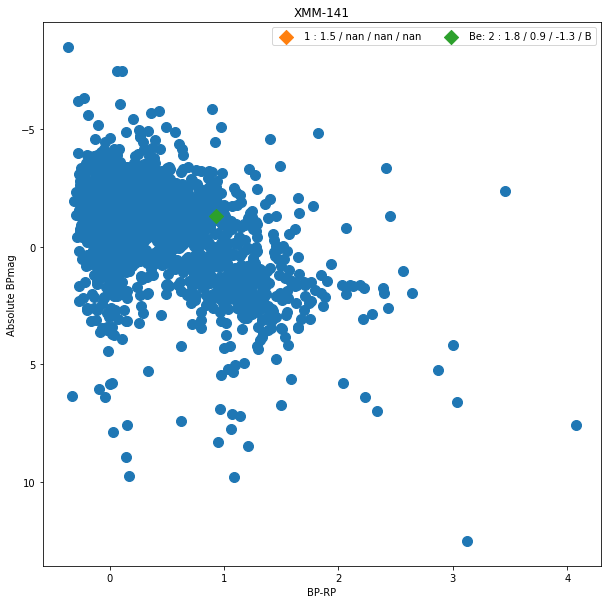

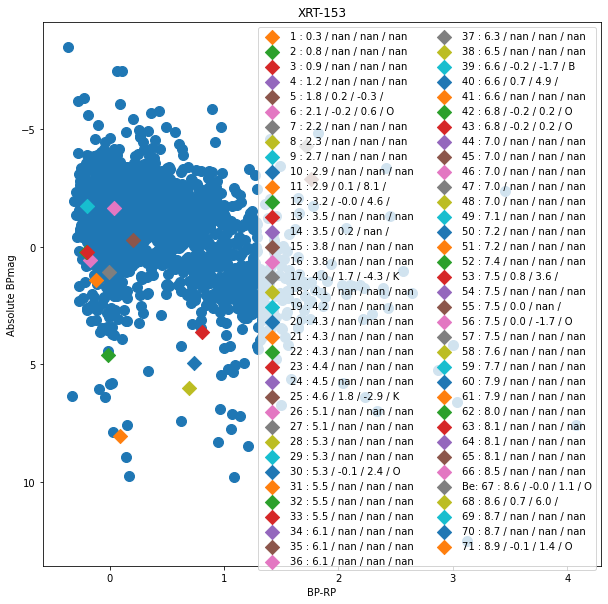

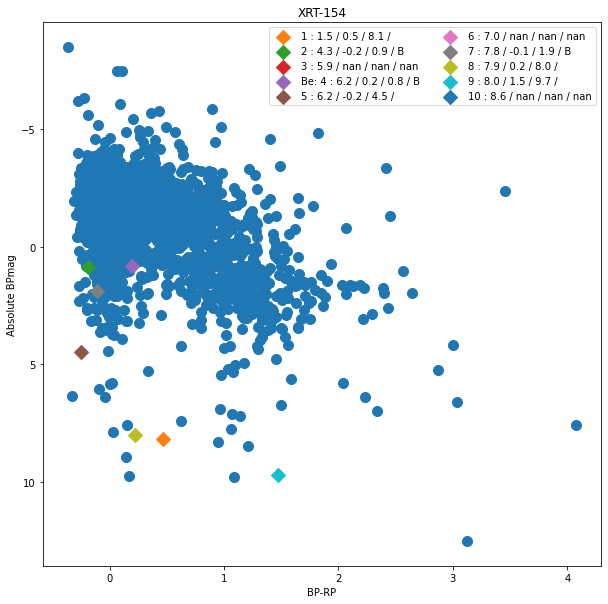

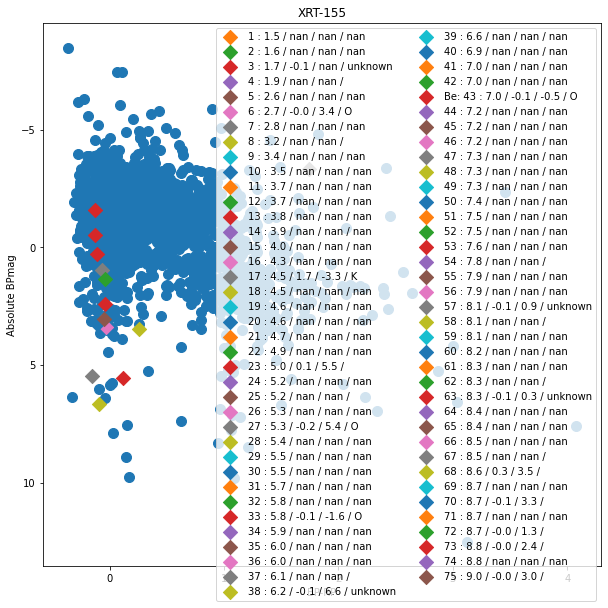

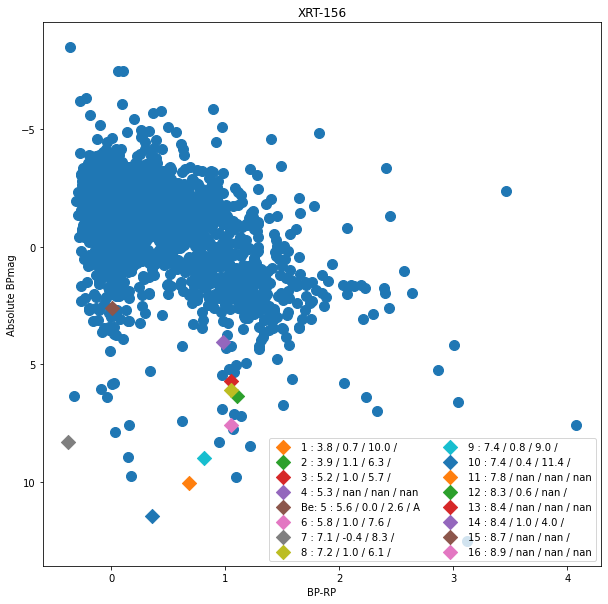

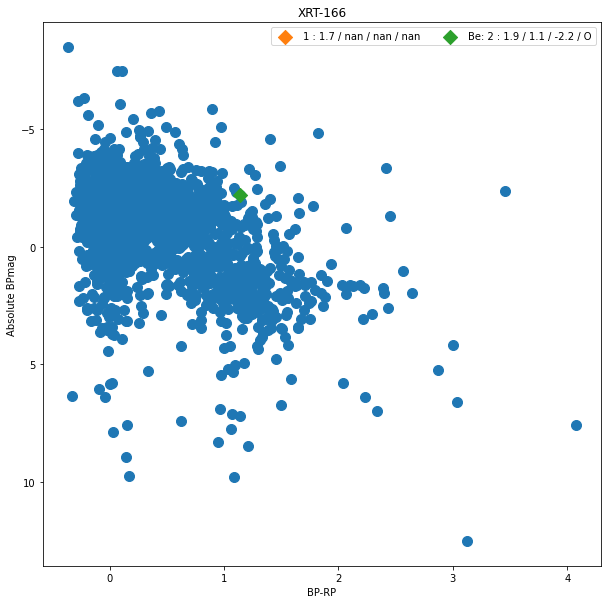

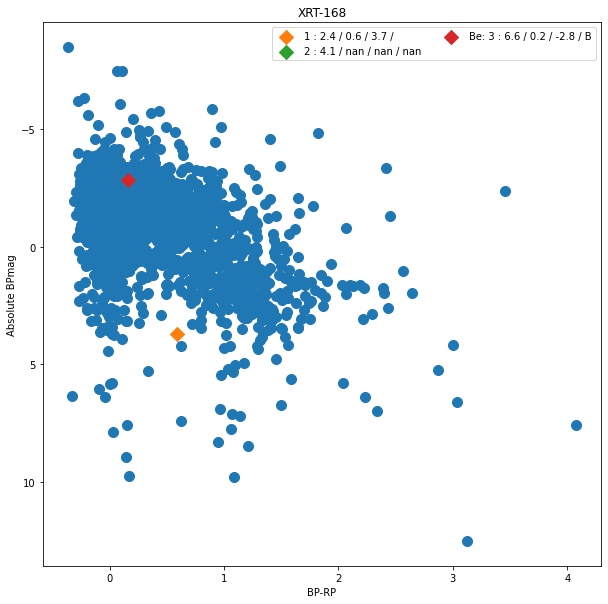

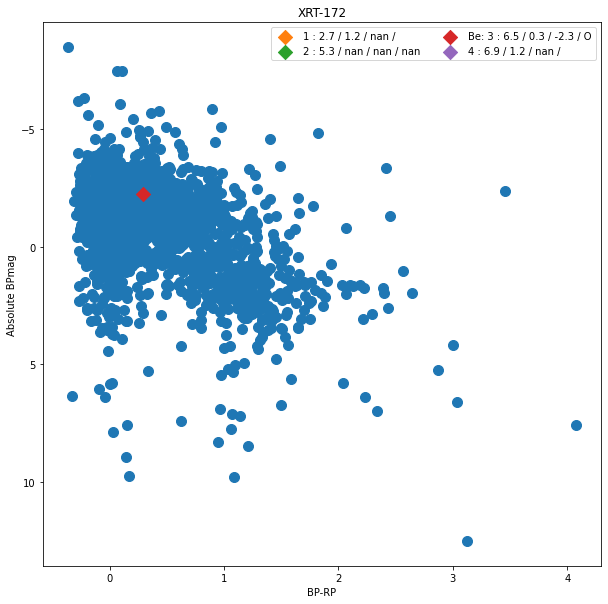

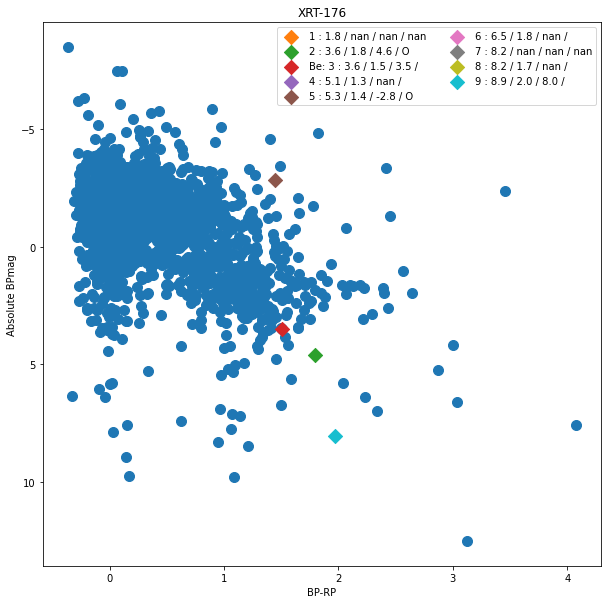

In [49]:
# marking questionable gaia counterparts of X-ray sources with multiple matches using conf_flag_X2O column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots
# selecting the nearest gaia matches with valid color and distance measurements (plotted along with their separation in ")


X_gaia_select = pd.DataFrame()

for i in X_gaia['_q'].unique():

    df_sub = X_gaia.loc[X_gaia['_q']==i].sort_values(by=['_r'])
    instances = len(df_sub)
    if instances == 1:
        X_gaia_select = X_gaia_select.append(df_sub, ignore_index=True)
    else:
        df_src = df_sub.loc[df_sub['_r'] ==min(df_sub['_r'])]
        if len(df_src)>1:
            df_nearest = df_src.head(1)
        else:
            df_nearest = df_src
            
        if df_nearest['Source'].values in df_gaia['Source'].values:
            
            X_gaia_select = X_gaia_select.append(df_nearest, ignore_index=True)
        
        if df_nearest['Source'].values not in df_gaia['Source'].values:
            print(xray.loc[xray.index==i-1, ['_RAJ2000_X','_DEJ2000_X','X_pos']])
            
            fig, ax = plt.subplots(figsize=(10,10))

            ax.scatter(df_gaia['BP-RP'], df_gaia['abs_BPmag'], s=100)

            j=1
            for s in df_sub.index:
                
                if df_sub.loc[s, 'Source'] in df_gaia['Source'].values:
                    print(df_comb.loc[df_comb.Source== df_sub.loc[s, 'Source'],['#','Be star','_RAJ2000', '_DEJ2000']])
                    
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="Be: %1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r_x'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                else:
                
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="%1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r_x'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                j+=1
            
            #df_sub_select = df_sub[(~df_sub['BP-RP'].isnull()) & (~df_sub['abs_BPmag'].isnull())].iloc[0]
            #df_sub_select['conf_flag_X2O'] = 4
            #X_gaia_select = X_gaia_select.append(df_sub_select, ignore_index=True)
            # #print(df_sub_select)
            #ax.text(df_sub_select['BP-RP'], df_sub_select['abs_BPmag'], str(df_sub_select['_r_x']), fontsize=12)
                
                
            plt.legend(ncol=2,fontsize=10)
            plt.gca().invert_yaxis()
            plt.xlabel('BP-RP')
            plt.ylabel('Absolute BPmag')
            plt.title(xray.loc[i-1, 'X_pos']+'-'+str(int(i)))

        
#print(cat,'\n')       

In [ ]:
# renaming some columns for gaia, xray and BeSS tables

pd.options.display.max_seq_items = 2000

X_gaia_select = X_gaia_select[['Source','_RAJ2000_x', '_DEJ2000_x','Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE','e_pmDE','epsi','sepsi','RUWE',
                               'Gmag', 'e_Gmag','BPmag', 'e_BPmag','RPmag','e_RPmag',
                               'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo','b_rpgeo', 'B_rpgeo', 'Flag', 'abs_BPmag', '_q', '_r','conf_flag_X2O'
                              ]]
X_gaia_select = X_gaia_select.rename(columns={'_RAJ2000_x':'_RAJ2000_gaia', '_DEJ2000_x':'_DEJ2000_gaia','_q':'_q_X', '_r':'_r_X'})
#print(X_gaia_select.columns)


xray = xray.drop(columns=['_RAJ2000_CSC', '_DEJ2000_CSC','_RAJ2000_XMM', '_DEJ2000_XMM','_RAJ2000_XRT', '_DEJ2000_XRT'])#.rename(columns={'_RAJ2000':'_RAJ2000_X', '_DEJ2000':'_DEJ2000_X'})
xray['index_X'] = xray.index+1
#print(xray.columns)


df_BeSS = df_BeSS[['index','name','mag','type','_RAJ2000', '_DEJ2000','conf_flag']].rename(columns={'name':'name_BeSS','mag':'mag_BeSS','type':'type_BeSS','_RAJ2000':'_RAJ2000_BeSS', '_DEJ2000':'_DEJ2000_BeSS'})
#print(df_BeSS.columns)

In [ ]:
# merging all three (gaia, xray and BeSS) tables 

master = pd.merge(df_BeSS, xray, left_on='index', right_on='_q', how='inner')
#print(len(master))
master = pd.merge(master, X_gaia_select, left_on = 'index_X', right_on='_q_X', how='inner')
print(len(master))

master.to_csv('master_BeSS_Xray_Gaia.csv', index=False) 

## matching with other multiwavelength catalogs (2mass, catwise, unwise, allwise) using 1" to gaia coordinates

In [30]:
master['_q_MW'] = master.index+1

cats = {
    'gaia':     'I/355/gaiadr3',
    'gaiadist': 'I/352/gedr3dis',
    '2mass':    'II/246/out',
    'catwise':  'II/365/catwise',
    'unwise':   'II/363/unwise',
    'allwise':  'II/328/allwise',
    'vphas':    'II/341'
    }

ras = master['_RAJ2000_gaia'].values
decs = master['_DEJ2000_gaia'].values

radec = [[ras[i], decs[i]] for i in range(len(ras))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))
        
for cat in ['2mass','catwise','unwise','allwise']:
    print(cat)
    
    viz = Vizier(row_limit=-1,  timeout=5000, columns=["**", "+_r"], catalog=cats[cat])
    
    query_res = viz.query_region(rd, radius=1.*u.arcsec)[0]
    df_MW = query_res.to_pandas()
    
    df_MW = find_nearest(df_MW, ind_col='_q', sep_col='_r').reset_index(drop=True)
    
    df_MW = df_MW.add_suffix('_'+cat)
    
    master = pd.merge(master, df_MW, left_on='_q_MW', right_on='_q_'+cat, how='outer')#, on=['_q_MW', '_q'])

2mass
Before cleaning multiple matches: 149 rows.
After cleaning multiple matches: 149 rows.
catwise
Before cleaning multiple matches: 113 rows.
After cleaning multiple matches: 112 rows.
unwise
Before cleaning multiple matches: 141 rows.
After cleaning multiple matches: 128 rows.
allwise
Before cleaning multiple matches: 126 rows.
After cleaning multiple matches: 126 rows.


In [31]:
# merging catwise and unwise catalogs for W1 and W2 bands

master.loc[:, 'W1mag_unwise'], master.loc[:, 'W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'W1mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW1_unwise']>0,'FW1_unwise']) - 0.004
master.loc[master['FW2_unwise']>0,'W2mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW2_unwise']>0,'FW2_unwise']) - 0.032
master.loc[:, 'e_W1mag_unwise'], master.loc[:, 'e_W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'e_W1mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW1_unwise']>0,'e_FW1_unwise']/master.loc[master['FW1_unwise']>0,'FW1_unwise']
master.loc[master['FW2_unwise']>0,'e_W2mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW2_unwise']>0,'e_FW2_unwise']/master.loc[master['FW2_unwise']>0,'FW2_unwise']

master = master.rename(columns={'W1mproPM_catwise':'W1mag_catwise','e_W1mproPM_catwise':'e_W1mag_catwise','W2mproPM_catwise':'W2mag_catwise','e_W2mproPM_catwise':'e_W2mag_catwise'})

for w in ['W1', 'W2']:
    master[w+'mag_comb'] = master[w+'mag_allwise']
    master['e_'+w+'mag_comb'] = master['e_'+w+'mag_allwise']
    
    s= np.where((master[w+'mag_comb'].isnull()) & (~master[w+'mag_catwise'].isnull()))[0]
    print(len(s), 'use ',w,' from CatWISE2020 rather than AllWISE.')
    master.loc[s, w+'mag_comb'] = master.loc[s, w+'mag_catwise']
    master.loc[s, 'e_'+w+'mag_comb'] = master.loc[s, 'e_'+w+'mag_catwise']
    
    s= np.where((master[w+'mag_comb'].isnull()) & (~master[w+'mag_unwise'].isnull()))[0]
    print(len(s), 'use ',w,' from UnWISE rather than AllWISE & CatWISE2020.')
    master.loc[s, w+'mag_comb'] = master.loc[s, w+'mag_unwise']
    master.loc[s, 'e_'+w+'mag_comb'] = master.loc[s, 'e_'+w+'mag_unwise']

9 use  W1  from CatWISE2020 rather than AllWISE.
7 use  W1  from UnWISE rather than AllWISE & CatWISE2020.
9 use  W2  from CatWISE2020 rather than AllWISE.
4 use  W2  from UnWISE rather than AllWISE & CatWISE2020.


In [32]:
# using rgeo for distance, correcting the distance for Gamma Cas

master['dist'] = master['rgeo']
master.loc[master['name_BeSS'] == 'gam Cas', 'dist'] = 168

In [33]:
# calculating some features 

master["HR_h_ms"] = (master['Flux (h band)'] - master['Flux (m band)'] - master['Flux (s band)']) / (master['Flux (h band)'] + master['Flux (m band)'] + master['Flux (s band)'])
master["HR_h_m"] = (master['Flux (h band)'] - master['Flux (m band)']) / (master['Flux (h band)'] + master['Flux (m band)'])
master["HR_m_s"] = (master['Flux (m band)'] - master['Flux (s band)']) / (master['Flux (m band)'] + master['Flux (s band)'])

master["Gflux"] = (2.5e-9*10**(master["Gmag"]/(-2.5))) * 4052.97 

master["Flux (b band)"] = master['Flux (h band)'] + master['Flux (m band)'] + master['Flux (s band)']

master['LX'] = master["Flux (b band)"] * 4 * np.pi * (master['dist']*3.086e+18)**2 

master['X-O-fluxratio'] = master["Flux (b band)"] / master["Gflux"]

master['BP-RP'] = master["BPmag"] - master["RPmag"]

In [34]:
# matching to Simbad using 2" 

master_simbad = XMatch.query(cat1=Table.from_pandas(master),
                         cat2='vizier:SIMBAD',max_distance=2 * u.arcsec, colRA1='_RAJ2000_gaia',colDec1='_DEJ2000_gaia')

#master_simbad.to_pandas().to_csv('master_simbad.csv')
master_simbad = find_nearest(master_simbad.to_pandas(), ind_col='index', sep_col='angDist')

master = pd.merge(master, master_simbad[['index','main_type','main_id']],on="index",  how="outer")
print(len(master))


Before cleaning multiple matches: 156 rows.
After cleaning multiple matches: 149 rows.
158


In [35]:
# adding catalog memberships that each source is matched to 

for i in master.index:
    flags = []
    
    for col, cat in zip(["_2CXO","_4XMM","_2SXPS","Source","_2MASS_2mass","objID_catwise","objID_unwise","AllWISE_allwise"], ["CSC","XMM","XRT","Gaia","2Mass","catwise","unwise","allwise"]):
        if pd.notna(master.loc[i,col]):
            flags.append(cat)
            
    master.loc[i,"Memberships"] = ",".join(flags)

In [36]:
master.to_csv('master_BeSS_Xray_Gaia_MW.csv', index=False)

In [37]:
# those sources have new CXO and XMM observations made 

#master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"] = master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"]+",CSC"
#master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"] = master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"]+",XMM"


# Adding classifications 

In [38]:
# assignning HMXB and YSO classifications based on Liu+2006 HMXB catalog and Simbad classifications

master_table = Table.from_pandas(master)
master_table["_RAJ2000"] = master_table["_RAJ2000_gaia"] *u.degree
master_table["_DEJ2000"] = master_table["_DEJ2000_gaia"] *u.degree

HMXBs_master = v.query_region(master_table, catalog="J/A+A/455/1165/table1", radius="1s")[0]

for i in range(len(master)):
    if i+1 in (HMXBs_master['_q']):
        master.loc[i,'Class'] = 'HMXB'
    elif master.loc[i,'main_type'] == 'HMXB':
        master.loc[i,'Class'] = 'HMXB'
    elif master.loc[i,'main_type'] == 'Orion_V*' or master.loc[i,'main_type'] == 'YSO':
         master.loc[i,'Class'] = 'YSO'
    else:
        master.loc[i,'Class'] = 'star'
        
print(Counter(master['Class']))

Counter({'star': 100, 'HMXB': 50, 'YSO': 8})


In [39]:
# assignning Gamma Cas Analogs classifications

gamma_cass = pd.read_csv("GammaCassAnalogs.csv")

gamma_cass_coordinates = SkyCoord(gamma_cass['ra'], gamma_cass['dec'], frame='icrs',unit=(u.hourangle, u.deg))

gamma_cass['_RAJ2000'] = gamma_cass_coordinates.ra.degree
gamma_cass['_DEJ2000'] = gamma_cass_coordinates.dec.degree

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, '_RAJ2000_gaia']* u.degree, master.loc[i, '_DEJ2000_gaia']* u.degree, frame='icrs')
    
    sep = c1.separation(gamma_cass_coordinates).arcsec
    if min(sep)<1.:
        master.loc[i,'Class'] = r'$\gamma$ Cas analog'

print(Counter(master['Class']))

Counter({'star': 89, 'HMXB': 47, '$\\gamma$ Cas analog': 14, 'YSO': 8})


In [40]:
# adding a few more 

master.loc[master['main_id'] == 'CD-29  5159', 'Class'] = 'HMXB'
master.loc[master['main_id'] == 'EM* MWC  659', 'Class'] = r'$\gamma$ Cas analog'
master.loc[master['main_id'] == '* pi. Aqr', 'Class'] = r'$\gamma$ Cas analog'
master.loc[master['main_id'] == 'HD  42054', 'Class'] = r'$\gamma$ Cas analog'

print(Counter(master['Class']))

Counter({'star': 85, 'HMXB': 48, '$\\gamma$ Cas analog': 17, 'YSO': 8})


In [41]:
# adding HMGB classification
  
for name, coord in zip(['1FGL J1018.6−5856','4FGL J1405.1−6119','LS I +61 303','LS 2883','HESS J0632+057','LS 5039','TeV J2032+4130'], [['10 19 02.270', '-58 56 29.87'], ['14 05 11.6', '-61 19 56'], ['02 40 31.6641883136', '+61 13 45.591138110'], ['13 02 47.6541729594','-63 50 08.62592286'], ['06 32 59.2566624297','+05 48 01.162565528'], ['18 26 15.0561532140', '-14 50 54.249464136'], ['20 32 06.0', '+41 34 00']]):
    HMGB_coordinates = SkyCoord(coord[0], coord[1], frame='icrs',unit=(u.hourangle, u.deg))
    #print(name, HMGB_coordinates)
    master_xray_coordinates = SkyCoord(master['_RAJ2000_gaia'], master['_DEJ2000_gaia'], frame='icrs',unit=(u.deg, u.deg))

    sep = HMGB_coordinates.separation(master_xray_coordinates).arcsec
    if min(sep)<1:
        #print(name, HMGB_coordinates,min(sep))
        ind = np.where(sep == min(sep))[0]
        #print(sep[ind])
        
        master.loc[ind,'Class'] = 'HMGB'
        master.loc[ind,'main_id'] = name
        
    
print(Counter(master['Class']))

Counter({'star': 85, 'HMXB': 45, '$\\gamma$ Cas analog': 17, 'YSO': 8, 'HMGB': 3})


In [42]:
# extinction & absorption

master['ebv']  = master.apply(lambda row: DustMap.ebv(SkyCoord(row._RAJ2000_gaia, row._DEJ2000_gaia, unit = 'deg'), dustmap='SFD')*0.86, axis=1)
master['nH']   = master.apply(lambda row: GasMap.nh(SkyCoord(row._RAJ2000_gaia, row._DEJ2000_gaia, unit = 'deg'), nhmap='LAB').value/1.e21, axis=1)


In [43]:
master.to_csv('master_all.csv',index=False)

master_xray = master

# some plottings 

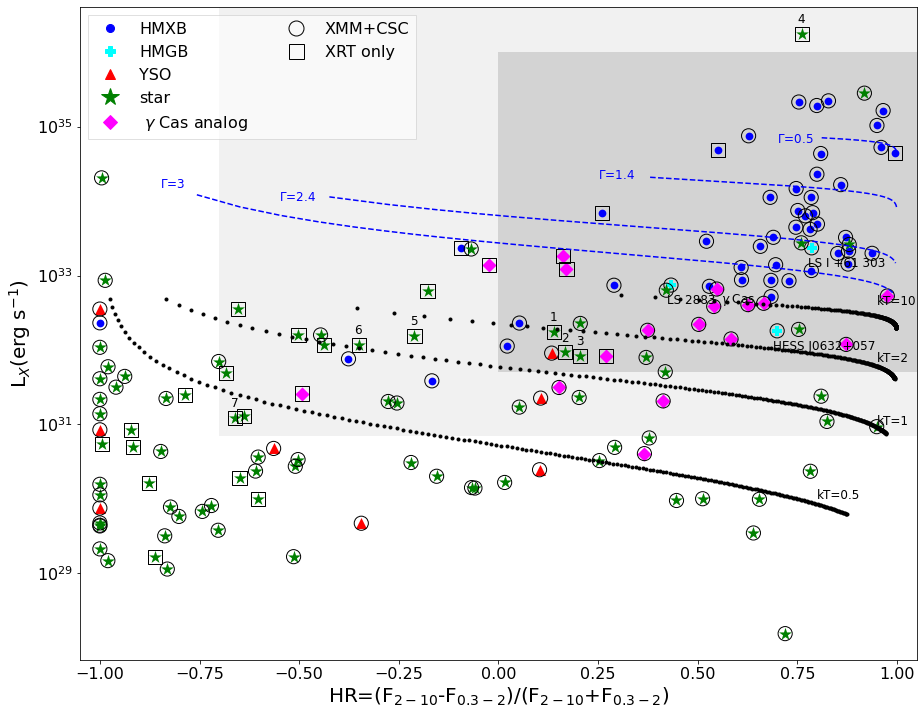

In [44]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,5e31),2.2,1e36, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=1))

ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2.2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))

for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
    
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        if model == 'pl':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 * 20,line, color=color, label=model)
        elif model == 'gas':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 /5e3,line, color=color, label=model)

ax.text(0.95, 4e32, 'kT=10', fontsize=12)
ax.text(0.95, 7e31, 'kT=2', fontsize=12)
ax.text(0.95, 1e31, 'kT=1', fontsize=12)
ax.text(0.8, 1e30, 'kT=0.5', fontsize=12)

ax.text(0.7, 6e34, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(0.25, 2e34, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.55, 1e34, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.85, 1.5e34, '$\\Gamma$=3', fontsize=12, color='b')
    
for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']-0.01, master_xray.loc[i,'LX']*0.55, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    #print(i, master_xray[master_xray['main_id']==src]['HR_2-10_0.3-2']-0.01)
    ax.text(master_xray.loc[master_xray['main_id']==src,'HR_2-10_0.3-2']-0.01, master_xray.loc[master_xray['main_id']==src,'LX']*1.4, str(i), fontsize=12)
    #print(i)
    

ax.set(ylim=(7e27,4e36), xlim=(-1.05,1.05),  yscale="log", xlabel=r'HR=(F$_{2-10}$-F$_{0.3-2}$)/(F$_{2-10}$+F$_{0.3-2}$)', ylabel=r"L$_X$(erg s$^{-1}$)")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]
               
                
legend = ax.legend(handles=legend_elements1+legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#legend = ax.legend(handles=legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("plots/LX_vs_HR_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

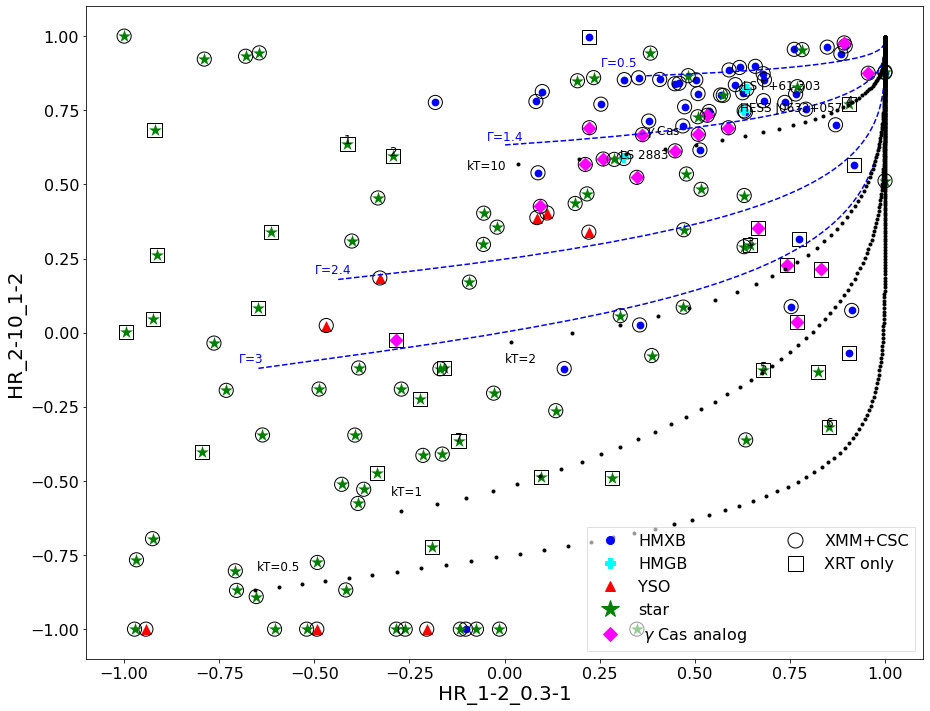

In [45]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
   
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        ax.plot( (df['f2']-df['f1'])/(df['f2']+df['f1']), (df['f3']-df['f2'])/(df['f3']+df['f2']),line, color=color)
                   

ax.text(-0.1, 0.55, 'kT=10', fontsize=12)
ax.text(0., -0.1, 'kT=2', fontsize=12)
ax.text(-0.3, -0.55, 'kT=1', fontsize=12)
ax.text(-0.65, -0.8, 'kT=0.5', fontsize=12)

ax.text(0.25, 0.9, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(-0.05, 0.65, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.5, 0.2, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.7, -0.1, '$\\Gamma$=3', fontsize=12, color='b')

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HR_1-2_0.3-1", y="HR_2-10_1-2", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_1-2_0.3-1"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_1-2"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_1-2_0.3-1"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_1-2"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_1-2_0.3-1']-0.01, master_xray.loc[i,'HR_2-10_1-2'], master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_1-2_0.3-1']+0.01, master_xray.loc[i,'HR_2-10_1-2'], r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    ax.text(master_xray.loc[master_xray['main_id']==src,'HR_1-2_0.3-1']-0.01, master_xray.loc[master_xray['main_id']==src,'HR_2-10_1-2'], str(i), fontsize=12)
    #print(i)
    
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]

legend = ax.legend(handles=legend_elements1+legend_elements2, loc='lower right', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("plots/HR1_vs_HR2_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

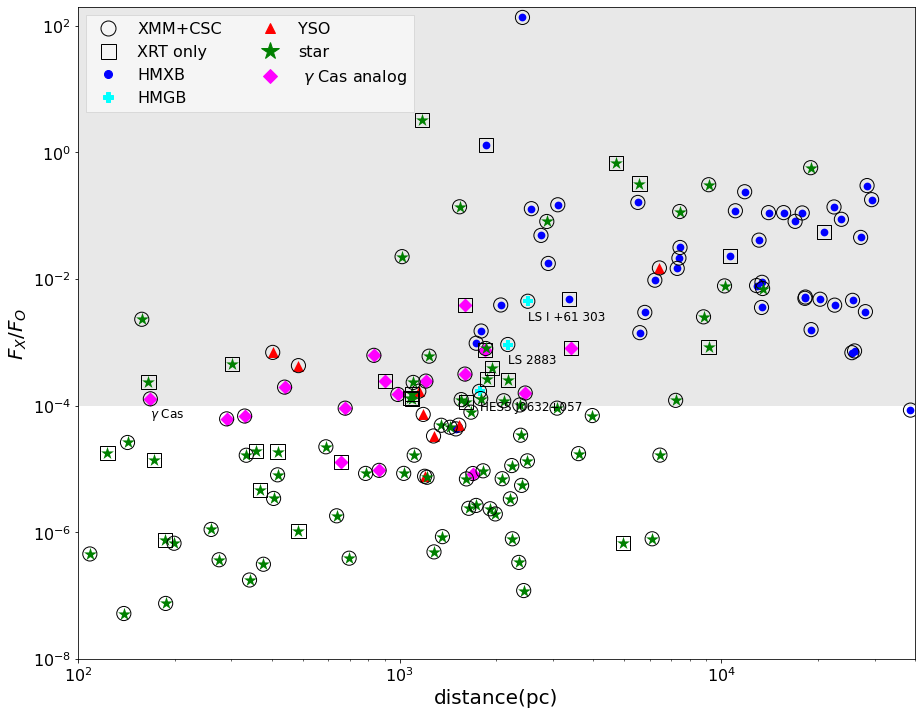

In [46]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="dist", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(100,40000), xscale="log", yscale="log", xlabel='distance(pc)', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

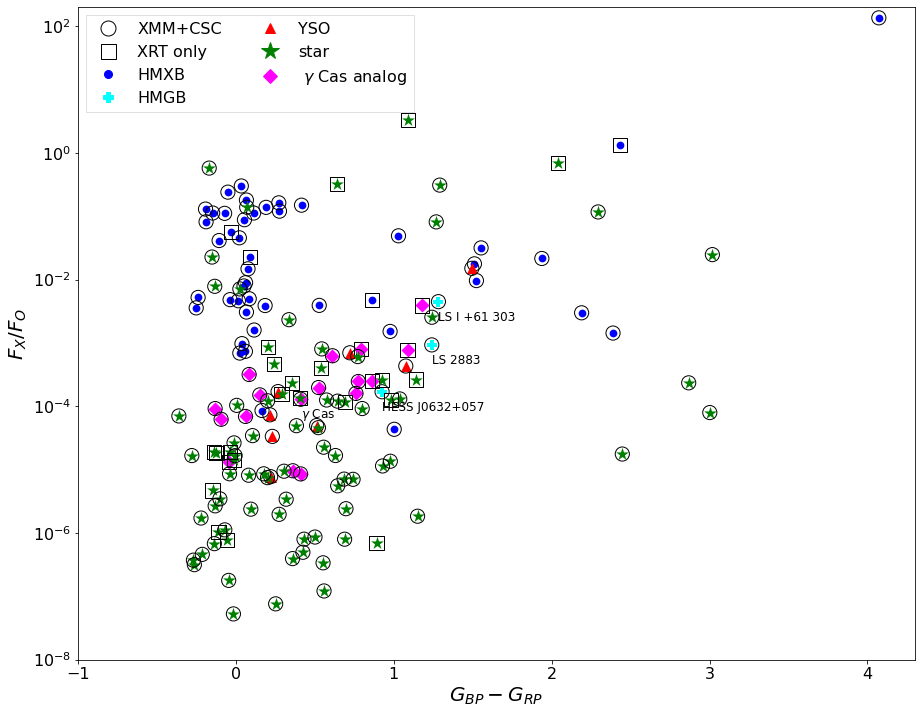

In [47]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="BP-RP", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(-1,4.3), yscale="log", xlabel=r'$G_{BP}-G_{RP}$', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

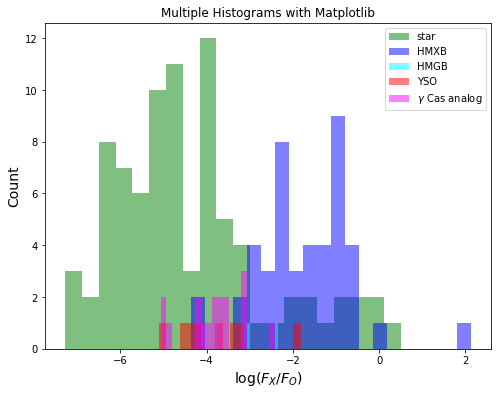

In [48]:
plt.figure(figsize=(8,6))

for clas, color in zip(['star','HMXB','HMGB','YSO','$\\gamma$ Cas analog', ], ['green','blue','cyan', 'red',  'magenta']):
    plt.hist(np.log10(master_xray.loc[(master_xray['Class']==clas) & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color=color,label=clas)
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='$\\gamma$ Cas analog') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, label="data1")
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='YSO') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color='r',label="data1")

#plt.hist(data2, bins=100, alpha=0.5, label="data2")

plt.xlabel("log($F_X/F_O$)", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

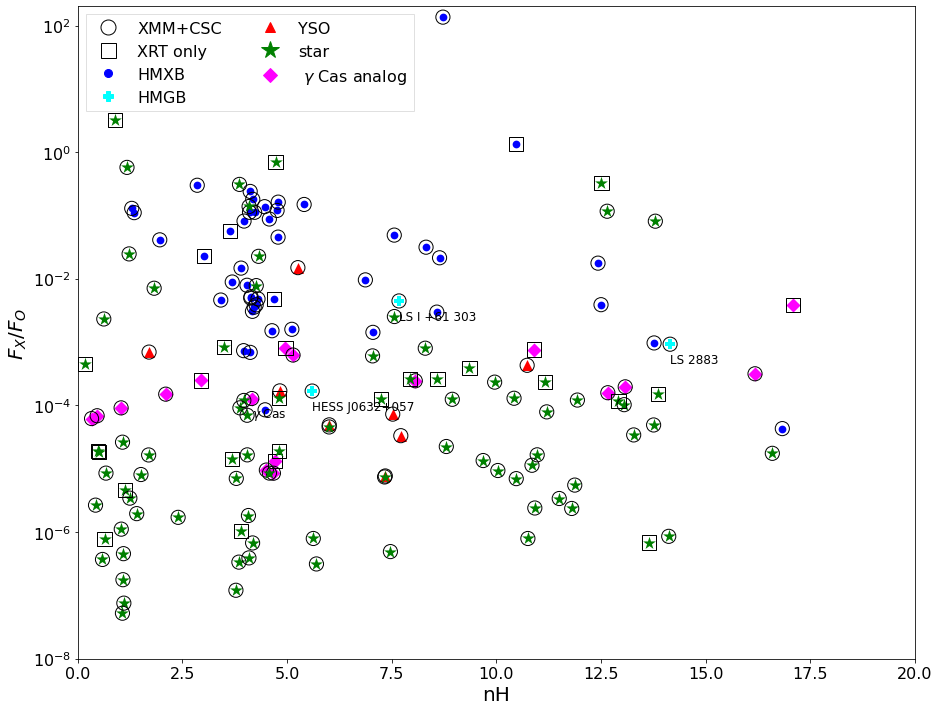

In [49]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="nH", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(0,20), yscale="log", xlabel='nH', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

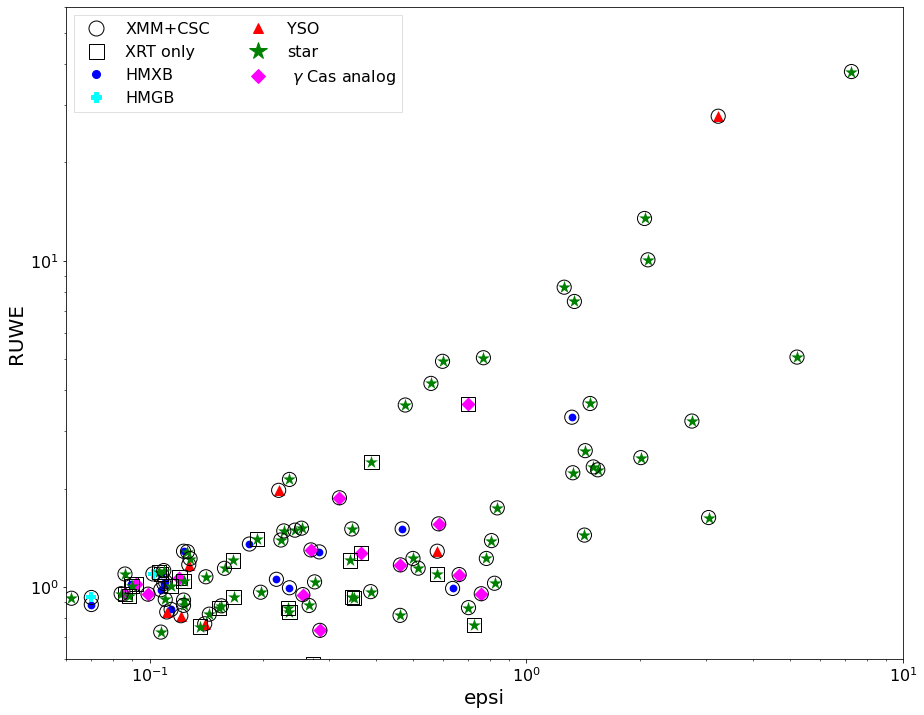

In [50]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas) & (master_xray['sepsi']>5)], x="epsi", y="RUWE", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


    
ax.set(xlim=(6e-2,10), ylim=(6e-1,60),  xscale="log", yscale="log", xlabel='epsi', ylabel="RUWE")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")